<img src="https://i.imgur.com/Ur83eQl.png"></img>

# (3-5) 성능 고도화 방법 실습

## 실습 개요

<hr style="height:5px;border:none;color:#5F71F7;background-color:#5F71F7">

### 1) 실습 목적
이번 실습에서는 강의에서 배웠던 다양한 딥러닝 성능 고도화 방법를 구현해봅니다. 이전 실습과 동일하게 MNIST를 이용하여 직접 NumPy로 신경망을 만들어 학습시키고 드롭아웃(Dropout), 가중치 초기화(Weight initialization) 그리고 배치 정규화(Batch Normalization)와 같은 성능 고도화 방법들을 구현하고 이를 직접 확인해보는 시간을 가져봅시다. 나아가 SGD부터 Adam에 이르기까지 다양한 옵티마이저(Optimizer)를 구현해봅니다.

### 2) 수강 목표
- 성능 고도화 방법 중 하나인 드롭아웃(Dropout)에 대해서 이해하고 구현할 수 있다.
- 딥러닝에서 대표적인 정규화 방법 중 배치 정규화(Batch Normalizaiton)에 대해서 이해하고 구현할 수 있다.
- SGD부터 Adam에 이르기까지 딥러닝에서 가장 많이 사용되는 옵티마이저(Optimizer)의 동작 원리를 이해하고 직접 구현할 수 있다.

### 실습 목차
1. [복습] 신경망 학습하기
2. 드롭아웃(Dropout)
3. 배치 정규화(Batch Normalization)
4. 딥러닝에서의 다양한 옵티마이저(Optimizer)
    - 4-1. SGD 이해 및 구현
    - 4-2. Momentum 이해 및 구현
    - 4-3. Nesterov 이해 및 구현
    - 4-4. AdaGrad 이해 및 구현
    - 4-5. RMSProp 이해 및 구현
    - 4-6. Adam 이해 및 구현



### 실습 구성
> 앞으로 여러분들이 마주하게 될 실습코드는 다음과 같이 3개의 종류로 구성되어 있습니다.

- 📝 <font color='orange'><b>[ 설명 ]</b></font> : 코드를 작성하기 전 필요한 지식
- 👨‍💻 <font color='green'><b>[ 코드 ]</b></font>  : 본격적인 코드 작성
- 📚 <font color='blue'><b>[ 자료 ]</b></font>  : 코드와 관련한 읽을거리

### 데이터셋 개요

<div align="center">
<img src="https://upload.wikimedia.org/wikipedia/commons/f/f7/MnistExamplesModified.png" alt="MNIST Test Data Samples">
</div>


* 데이터셋 :
MNIST(Modified National Institute of Standards and Technology) Database

* 데이터셋 개요 :
<br>&ensp;&ensp;MNIST 데이터셋은 미국의 NIST에서 이미지 처리 시스템을 위해 모은 손글씨 이미지 데이터셋 NIST Special Database 3 중 일부를 재구성한 것으로, 0부터 9까지의 숫자 이미지와 이에 대응되는 숫자가 한 쌍으로 구성되어 있습니다. 이 데이터셋은 머신러닝 및 딥러닝 분야에서 가장 잘 알려진 벤치마크 데이터셋 중 하나로, 특히 딥러닝 기초 관련 교보재에 주로 활용되고 있습니다.

  - 데이터셋 구성
    - 입력(이미지) : 0부터 9까지의 숫자 중 하나에 속하는 64px * 64px의 흑백 이미지
    - 출력(숫자) : 주어진 이미지에 대응되는 숫자 (0~9)
  - 데이터 샘플 수
    - 학습 데이터&ensp;&ensp;: 60,000 개
    - 테스트 데이터&thinsp;: 10,000 개

* 데이터셋 저작권: [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/)



### 환경 설정
해당 실습은 Google Colab을 기준으로 제작되었습니다. 실습에서 필요한 패키지 정보는 아래와 같습니다.
```
numpy >= 1.23.5
pandas >= 1.5.3
matplotlib >= 3.7.1
```

## 1. [복습] 신경망 학습하기

<hr style="height:5px;border:none;color:#5F71F7;background-color:#5F71F7">

성능 고도화 방법에 대해서 알아보기 전에, 이전 실습에서 배웠던 내용을 다시 복습해봅시다.

### 실습 환경 설정

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 라이브러리 및 옵션

In [3]:
import os
import sys
import gzip
import pickle
import random
import platform
import warnings
import datetime
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import OrderedDict
from urllib.request import urlretrieve

실습을 위해서 데이터셋 폴더를 생성하고 여기로 Google Colab을 마운트합니다.

In [4]:
# 재현성을 위해 랜덤 시드를 고정
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# 현재 OS 및 라이브러리 버전 체크 체크
current_os = platform.system()
print(f"Current OS: {current_os}")
print(f"Python Version: {platform.python_version()}")

# 중요하지 않은 에러 무시
warnings.filterwarnings(action='ignore')

# 유니코드 깨지는 현상 해결
mpl.rcParams['axes.unicode_minus'] = False

Current OS: Linux
Python Version: 3.10.12


### MNIST 데이터셋 가져오기

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> MNIST 데이터셋 다운로드 및 압축 해제

In [5]:
# MNIST를 다운받을 경로
url = 'http://yann.lecun.com/exdb/mnist/'

# MNIST를 저장할 디렉토리 (`./data/`)
dataset_dir = os.path.join(os.getcwd(), 'data')

# Pickle로 저장할 경로
save_file = dataset_dir + "/mnist.pkl"

# MNIST 데이터셋의 파일명 (딕셔너리)
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

# 해당 경로가 없을 시 디렉토리 새로 생성
os.makedirs(dataset_dir, exist_ok=True)

# 해당 경로에 존재하지 않는 파일을 모두 다운로드
for filename in key_file.values():
    if filename not in os.listdir(dataset_dir):
        urlretrieve(url + filename, os.path.join(dataset_dir, filename))
        print("Downloaded %s to %s" % (filename, dataset_dir))

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> MNIST 데이터셋 불러오기

In [6]:
def _load_label(file_name):
    """MNIST 데이터셋 라벨을 NumPy Array로 변환하여 불러오기
    """
    file_path = dataset_dir + "/" + file_name
    with gzip.open(file_path, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)
    return labels

def _load_img(file_name):
    """MNIST 데이터셋 이미지을 NumPy Array로 변환하여 불러오기
    """
    file_path = dataset_dir + "/" + file_name
    with gzip.open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, 28*28)
    return data

def _convert_numpy():
    """NumPy Array로 불러온 MNIST 데이터셋을 딕셔너리로 매핑
    """
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])
    return dataset

def init_mnist():
    """MNIST 데이터셋을 Pickle화
    """
    dataset = _convert_numpy()
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
    return T

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """MNIST 데이터셋 읽기
    """
    # Pickle화 됐는지 확인
    if not os.path.exists(save_file):
        init_mnist()

    # Pickle화된 MNIST 데이터셋 가져오기
    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)

    # 이미지의 픽셀 값을 0.0~1.0 사이의 값으로 정규화
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0

    # 레이블을 원-핫(one-hot) 배열로 변환
    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])

    # 입력 이미지를 1차원 배열로 만듬
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label'])

In [7]:
# MNIST 데이터셋 불러오기
(X_train, y_train), (X_test, y_test) = load_mnist()

In [8]:
# 학습 데이터의 인덱스를 랜덤하게 셔플
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)

# 섞인 인덱스를 기반으로 train과 valid 데이터 분할
# 과적합이 되는 상황을 유도하기 위해서 데이터의 수를 줄임
valid_idx = indices[:10000]
train_idx = indices[10000:]

# 학습 데이터 중 일부를 검증 데이터로 활용
X_valid, y_valid = X_train[valid_idx], y_train[valid_idx]
X_train, y_train = X_train[train_idx], y_train[train_idx]

In [9]:
# MNIST 데이터셋 살펴보기
print(f"학습 데이터: {len(X_train):,}개\n검증 데이터: {len(X_valid):,}개\n평가 데이터: {len(X_test):,}개")

학습 데이터: 50,000개
검증 데이터: 10,000개
평가 데이터: 10,000개


#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> MNIST 데이터셋 살펴보기

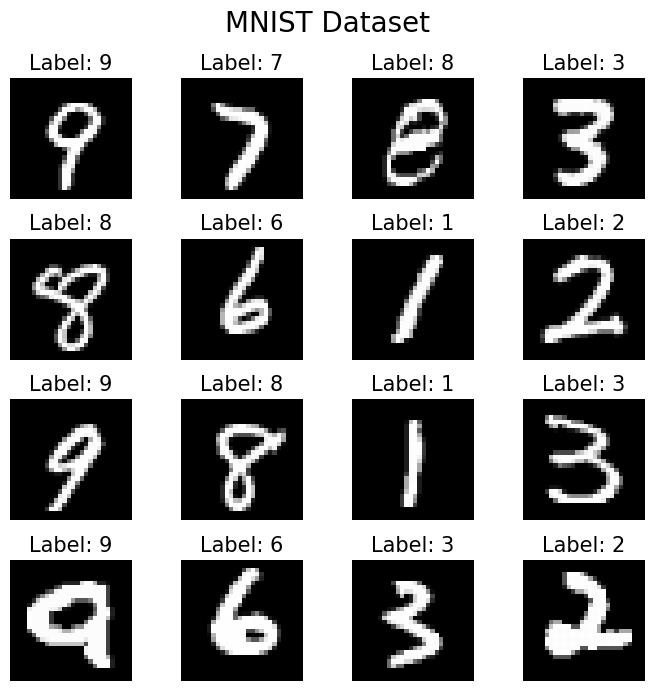

In [10]:
# MNIST 데이터셋 중 임의로 16개의 샘플 살펴봅시다
plt.figure(figsize=(7,7))
for n, i in enumerate(np.random.randint(0, len(X_train), size=16), start=1):
    plt.subplot(4,4,n)
    plt.imshow(X_train[i].reshape(28,28), cmap='gray')
    plt.title(f"Label: {y_train[i]}", fontsize=15)
    plt.axis('off')
plt.suptitle('MNIST Dataset', fontsize=20)
plt.tight_layout()
plt.show()

### Trainer 클래스를 활용하여 딥러닝 파이프라인 만들기

이번 실습에서는 Trainer 객체를 중심으로 간단한 신경망 모델을 구현해볼 예정입니다. Trainer 객체는 모델 학습의 전체 과정을 효율적으로 관리하고, 코드의 재사용성을 높이는 역할을 합니다. 이를 위해 각각의 활성화 레이어, 완전 연결 레이어, 소프트맥스 레이어를 구현한 뒤, 옵티마이저와 평가지표를 설정합니다. 이러한 구성요소들을 모아 전체적인 신경망을 만들고, 최종적으로는 이를 관리할 Trainer 객체를 구현합니다. 아래는 성능을 높이기 위한 기본 구현 코드입니다.

- 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 1. 시그모이드 활성화 레이어 구현하기
- 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 2. ReLU 활성화 레이어 구현하기
- 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 3. 완전 연결 레이어 구현하기
- 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 4. 소프트맥스 레이어 구현하기
- 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 5. 전체적인 신경망 구현하기
- 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 6. 옵티마이저 구현하기
- 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 7. 평가 지표 구현하기
- 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 8. Trainer 객체 구현하기

이렇게 Trainer 객체를 중심으로 구현하는 방식은 코드의 구조를 더 명확하게 하고, 나중에 다른 프로젝트나 더 복잡한 모델로 확장하기 쉽게 만들어줍니다.

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 1. 시그모이드 활성화 레이어 구현하기

In [11]:
def sigmoid(x):
    '''시그모이드 함수'''
    return 1 / (1 + np.exp(-x))

In [12]:
def sigmoid_grad(x):
    '''시그모이드 함수의 그래디언트'''
    return (1.0 - sigmoid(x)) * sigmoid(x)

In [13]:
class Sigmoid:
    '''시그모이드 레이어'''
    def __init__(self):
        self.out = None

    def forward(self, x):
        '''시그모이드 레이어의 순전파(forward propagation)'''
        self.out = sigmoid(x)  # 순전파가 흐를 시 그 결과물을 attribute로 저장 및 리턴
        return self.out

    def backward(self, dout):
        '''시그모이드 레이어의 역전파(backpropagation)'''
        dx = dout * (1.0 - self.out) * self.out
        return dx  # 역전파가 흐를시 그 그래디언트 값을 리턴

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 2. ReLU 활성화 레이어 구현하기 (NEW!)

In [14]:
def relu(x):
    '''ReLU 함수'''
    return np.maximum(0, x)

In [15]:
def relu_grad(x):
    '''ReLU 함수의 그래디언트'''
    grad = np.zeros(x)
    grad[x >= 0] = 1
    return grad

In [16]:
class Relu:
    '''ReLU 레이어'''
    def __init__(self):
        self.mask = None

    def forward(self, x):
        '''ReLU 레이어의 순전파(forward propagation)'''
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out  # 순전파가 흐를 시 그 결과물을 attribute로 저장 및 리턴

    def backward(self, dout):
        '''ReLU 레이어의 역전파(backpropagation)'''
        dout[self.mask] = 0
        dx = dout
        return dx  # 역전파가 흐를시 그 그래디언트 값을 리턴

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 3. 완전 연결 레이어 구현하기

> 신경망을 구성하게 될 각각의 MLP 레이어를 클래스 형태로 구현합니다.
> <br>MLP 모델을 구성하는 레이어는 fully-connected layer, linear layer, dense layer 등의 다양한 이름으로 불리고 있습니다.
> <br>본 실습에서는 `FCLayer`라는 이름으로 클래스를 정의하도록 하겠습니다.

In [17]:
class FCLayer:
    '''완전 연결 레이어'''
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.original_x_shape = None
        self.dW = None
        self.db = None

    def forward(self, x):
        '''완전 연결 레이어의 순전파(forward propagation)'''
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x
        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        '''완전 연결 레이어의 역전파(backpropagation)'''
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        dx = dx.reshape(*self.original_x_shape)

        return dx

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 4. 소프트맥스 레이어 구현하기

In [18]:
def softmax(x):
    '''소프트맥스 함수'''
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x)

    return np.exp(x) / np.sum(np.exp(x))

#### 📝 <font color='orange'><b>[ 설명 ]</b></font> 교차엔트로피(CE) 손실 함수 및 도함수의 수식

$$
L(y,\hat{y}) = \frac{-1}{n}\sum_{i=1}^n y_i\log(\hat{y}_i)+(1-y_i)(\log(1-\hat{y}_i)
$$

$$
\frac{dL}{d\hat y} = \frac{-1}{n}\left(\frac{y_i}{\hat{y}_i} - \frac{1-y_i}{1 - \hat{y}_i}\right) = \frac{\hat{y}_i-y_i}{n(1-\hat{y}_i)\hat{y}_i}
$$

In [19]:
def cross_entropy_error(y_true, y_pred):
    if y_true.ndim == 1:
        y_pred = y_pred.reshape(1, y_pred.size)
        y_true = y_true.reshape(1, y_true.size)

    if y_pred.size == y_true.size:
        y_pred = y_pred.argmax(axis=1)

    batch_size = y_true.shape[0]

    return -np.sum(np.log(y_true[np.arange(batch_size), y_pred] + 1e-7)) / batch_size

In [20]:
class Softmax:
    '''소프트맥스 레이어'''
    def __init__(self):
        self.loss = None
        self.y_true = None
        self.y_pred = None

    def forward(self, x, y_pred):
        '''소프트맥스 레이어의 순전파(forward propagation)'''
        self.y_true = softmax(x)
        self.y_pred = y_pred
        self.loss = cross_entropy_error(self.y_true, self.y_pred)

        return self.loss

    def backward(self, dout=1):
        '''소프트맥스 레이어의 역전파(backpropagation)'''
        batch_size = self.y_pred.shape[0]
        if self.y_pred.size == self.y_true.size:
            dx = (self.y_true - self.y_pred) / batch_size
        else:
            dx = self.y_true.copy()
            dx[np.arange(batch_size), self.y_pred] -= 1
            dx = dx / batch_size

        return dx

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 5. 전체적인 신경망 구현하기
앞서 구현한 모든 레이어를 바탕으로 최종적인 신경망을 구현해볼까요?

In [21]:
class Net:
    def __init__(self,
                 input_size,
                 hidden_size_list,
                 output_size,
                 use_dropout=False,
                 dropout_ratio=0,
                 use_batchnorm=False,
                 activation='relu',
                 weight_init_std='relu',
                 weight_decay_lambda=0
                 ):

        # 네트워크의 초기화
        self.input_size = input_size                    # 입력 크기 (예: 이미지의 픽셀 수)
        self.output_size = output_size                  # 출력 크기 (예: 분류할 클래스 수)
        self.hidden_size_list = hidden_size_list        # 은닉층의 뉴런 수 리스트
        self.hidden_layer_num = len(hidden_size_list)   # 은닉층의 개수
        self.weight_decay_lambda = weight_decay_lambda  # 가중치 감쇠
        self.use_dropout = use_dropout                  # 드롭아웃 사용 여부
        self.dropout_ratio = dropout_ratio              # 드롭아웃 사용시 계수
        self.use_batchnorm = use_batchnorm              # 배치 정규화 사용 여부

        # 신경망의 가중치
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 활성화 함수 지정 (ReLU, Sigmoid 등)
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}

        # 신경망의 레이어
        self.layers = OrderedDict()

        # 은닉층 생성
        for idx in range(1, self.hidden_layer_num+1):

            # 완전 연결 레이어 (Fully Connected Layer)
            self.layers[f'FC{idx}'] = FCLayer(
                self.params[f'W{idx}'],
                self.params[f'b{idx}']
            )

            # 배치 정규화 사용 여부에 따른 레이어 추가
            if self.use_batchnorm:
                self.params[f'gamma{idx}'] = np.ones(hidden_size_list[idx-1])
                self.params[f'beta{idx}'] = np.zeros(hidden_size_list[idx-1])
                self.layers[f'BN{idx}'] = BatchNormalization(
                    self.params[f'gamma{idx}'],
                    self.params[f'beta{idx}']
                )

            # 활성화 레이어 (Activation Layer: 예를 들면 ReLU나 Sigmoid)
            self.layers[f'Act{idx}'] = activation_layer[activation]()

            # 드롭아웃 사용 여부에 따른 레이어 추가
            if self.use_dropout:
                self.layers[f'Dropout{idx}'] = Dropout(self.dropout_ratio)

        # 출력층 (Last layer)
        idx = self.hidden_layer_num + 1
        self.layers[f'FC{idx}'] = FCLayer(
            self.params[f'W{idx}'],
            self.params[f'b{idx}']
        )

        # 소프트맥스 함수를 마지막 계층으로 설정 (분류 문제의 경우)
        self.last_layer = Softmax()

    def __init_weight(self, weight_init_std):
        """
        신경망의 가중치를 초기화합니다.
        Xavier 방식과 He 방식이 있습니다.
        """
        # 전체 네트워크의 각 층의 뉴런 수를 리스트로 구성
        all_size_list = [self.input_size] + \
            self.hidden_size_list + [self.output_size]

        # 모든 층을 순회하며 가중치를 초기화
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std

            # ReLU 활성화 함수를 사용할 경우 He 초기화 방법 사용
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])

            # Sigmoid 활성화 함수를 사용할 경우 Xavier 초기화 방법 사용
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])

            # 가중치와 편향 초기화
            self.params[f'W{idx}'] = scale * \
                np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params[f'b{idx}'] = np.zeros(all_size_list[idx])

    def predict(self, x, train_flag=False):
        """
        입력 데이터(x)에 대한 예측 값을 반환합니다.
        """
        for key, layer in self.layers.items():
            # 드롭아웃 또는 배치 정규화 레이어일 경우 train_flag를 사용
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flag)
            else:
                x = layer.forward(x)
        return x

    def loss(self, y_pred, y_true):
        """
        정답(y_true)와 예측 값(y_pred)을 기반으로 손실 값을 계산합니다.
        L2 정규화(L2 Regularization)가 적용된 가중치 감쇠를 포함합니다.
        """
        weight_decay = 0

        # 가중치 감쇠 계산
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params[f'W{idx}']
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y_true, y_pred) + weight_decay

    def gradient(self):
        """
        신경망의 그래디언트(미분값)를 계산합니다.
        이는 네트워크의 파라미터 업데이트에 사용됩니다.
        """
        # 역전파 시작
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 그래디언트 초기화
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads[f'W{idx}'] = self.layers[f'FC{idx}'].dW + \
                self.weight_decay_lambda * self.layers[f'FC{idx}'].W
            grads[f'b{idx}'] = self.layers[f'FC{idx}'].db

            # 배치 정규화를 사용하는 경우 gamma와 beta에 대한 그래디언트도 계산
            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads[f'gamma{idx}'] = self.layers[f'BN{idx}'].dgamma
                grads[f'beta{idx}'] = self.layers[f'BN{idx}'].dbeta

        return grads

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 6. 옵티마이저 구현하기  (NEW!)
SGD 옵티마이저를 클래스로 만들어 update함수를 구현합니다.

In [22]:
class SGD:
    '''SGD 옵티마이저'''
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 7. 평가 지표 구현하기  (NEW!)
모델 평가를 위한 지표인 정확도를 함수로 구현합니다.

In [23]:
def accuracy(y_true, y_pred, batch_size):
    """
    정확도를 계산합니다.
    """
    y_pred = np.argmax(y_pred, axis=1)

    if y_pred.ndim != 1:
        y_pred = np.argmax(y_pred, axis=1)

    assert y_true.shape == y_pred.shape

    # 실제 라벨과 예측 라벨이 일치하는 개수를 계산하여 정확도 반환
    return np.sum(y_true == y_pred) / float(batch_size)

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 8. Trainer 구현하기  (NEW!)

위에서 준비한 신경망과 옵티마이저를 이용해서 학습할 수 있게 Trainer 클래스를 구현합니다. 이는 이후 이어지는 실험들을 효율적으로 할 수 있게 도와줍니다.

In [24]:
class Trainer:
    def __init__(
        self,
        X_train,
        y_train,
        X_valid,
        y_valid,
        model,
        optimizer,
        max_iterations,
        batch_size,
    ):

        # 데이터셋
        self.X_train = X_train
        self.y_train = y_train
        self.X_valid = X_valid
        self.y_valid = y_valid

        # 모델
        self.model = model

        # 옵티마이저
        self.optimizer = optimizer

        self.train_size = X_train.shape[0]
        self.batch_size = batch_size
        self.max_iterations = max_iterations

        self.train_loss_list = []
        self.train_acc_list = []
        self.valid_loss_list = []
        self.valid_acc_list = []

    def run(self,):
        """신경망과 옵티마이저를 이용해서 학습하는 함수"""
        start_time = datetime.datetime.now()

        for i in range(self.max_iterations):
            ####################################################################
            # 학습
            ####################################################################
            batch_mask = np.random.choice(self.train_size, self.batch_size)
            X_batch = self.X_train[batch_mask]
            y_batch = self.y_train[batch_mask]

            # 예측 수행
            y_pred = self.model.predict(X_batch, train_flag=True)

            # 손실 계산
            train_loss = self.model.loss(y_batch, y_pred)
            self.train_loss_list.append(train_loss)

            # 정확도 계산
            train_acc = accuracy(y_batch, y_pred, self.batch_size)
            self.train_acc_list.append(train_acc)

            # Gradient 계산
            grads = self.model.gradient()

            # Optimizer 업데이트
            self.optimizer.update(self.model.params, grads)

            ####################################################################
            # 검증
            ####################################################################
            batch_mask = np.random.choice(X_valid.shape[0], self.batch_size)
            X_batch = self.X_valid[batch_mask]
            y_batch = self.y_valid[batch_mask]

            # 예측 수행
            y_pred = self.model.predict(X_batch, train_flag=False)

            # 손실 계산
            valid_loss = self.model.loss(y_batch, y_pred)
            self.valid_loss_list.append(valid_loss)

            # 정확도 계산
            valid_acc = accuracy(y_batch, y_pred, self.batch_size)
            self.valid_acc_list.append(valid_acc)

            if i % 100 == 0:
                elpased_time = datetime.datetime.now() - start_time
                msg = f"\033[31m[Elpased Time: {elpased_time}]\033[0m "
                msg += f"Iter: {i:>4} "
                msg += f"Train Loss : {train_loss:.4f} "
                msg += f"Train Acc : {train_acc:.2f} "
                msg += f"Valid Loss : {valid_loss:.4f} "
                msg += f"Valid Acc : {valid_acc:.2f} "
                print(msg)

    def show_results(self,):
        """학습된 결과를 시각화해주는 함수"""
        plt.figure(figsize=(16,8))

        plt.subplot(2,1,1)
        plt.plot(self.train_loss_list)
        plt.plot(self.valid_loss_list)
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Valid'])
        plt.grid(True)

        plt.subplot(2,1,2)
        plt.plot(self.train_acc_list)
        plt.plot(self.valid_acc_list)
        plt.xlabel('Iterations')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Valid'])
        plt.ylim(0,1.05)
        plt.grid(True)

        plt.suptitle(f'Result - Loss & Acc', fontsize=20)
        plt.tight_layout()
        plt.show()

#### 📝 <font color='orange'><b>[ 설명 ]</b></font> Trainer 예제
Trainer 객체를 생성해서 여기에 신경망과 옵티마이저를 넣어 실행시켜봅시다. 실행시킬 때는 `run`메소드를 이용합니다.

[Elpased Time: 0:00:00.013247] Iter:    0 Train Loss : 2.3516 Train Acc : 0.12 Valid Loss : 2.3331 Valid Acc : 0.17 
[Elpased Time: 0:00:00.666809] Iter:  100 Train Loss : 1.2735 Train Acc : 0.79 Valid Loss : 1.5762 Valid Acc : 0.63 
[Elpased Time: 0:00:01.277887] Iter:  200 Train Loss : 0.6815 Train Acc : 0.91 Valid Loss : 1.0553 Valid Acc : 0.69 
[Elpased Time: 0:00:01.995166] Iter:  300 Train Loss : 0.2920 Train Acc : 0.99 Valid Loss : 0.8514 Valid Acc : 0.77 
[Elpased Time: 0:00:02.658707] Iter:  400 Train Loss : 0.2148 Train Acc : 0.98 Valid Loss : 0.7300 Valid Acc : 0.76 
[Elpased Time: 0:00:03.311231] Iter:  500 Train Loss : 0.1191 Train Acc : 0.99 Valid Loss : 0.6606 Valid Acc : 0.80 
[Elpased Time: 0:00:03.829612] Iter:  600 Train Loss : 0.0912 Train Acc : 1.00 Valid Loss : 0.7263 Valid Acc : 0.78 
[Elpased Time: 0:00:04.524471] Iter:  700 Train Loss : 0.0660 Train Acc : 1.00 Valid Loss : 0.5204 Valid Acc : 0.78 
[Elpased Time: 0:00:05.081843] Iter:  800 Train Loss : 0.0385 Tr

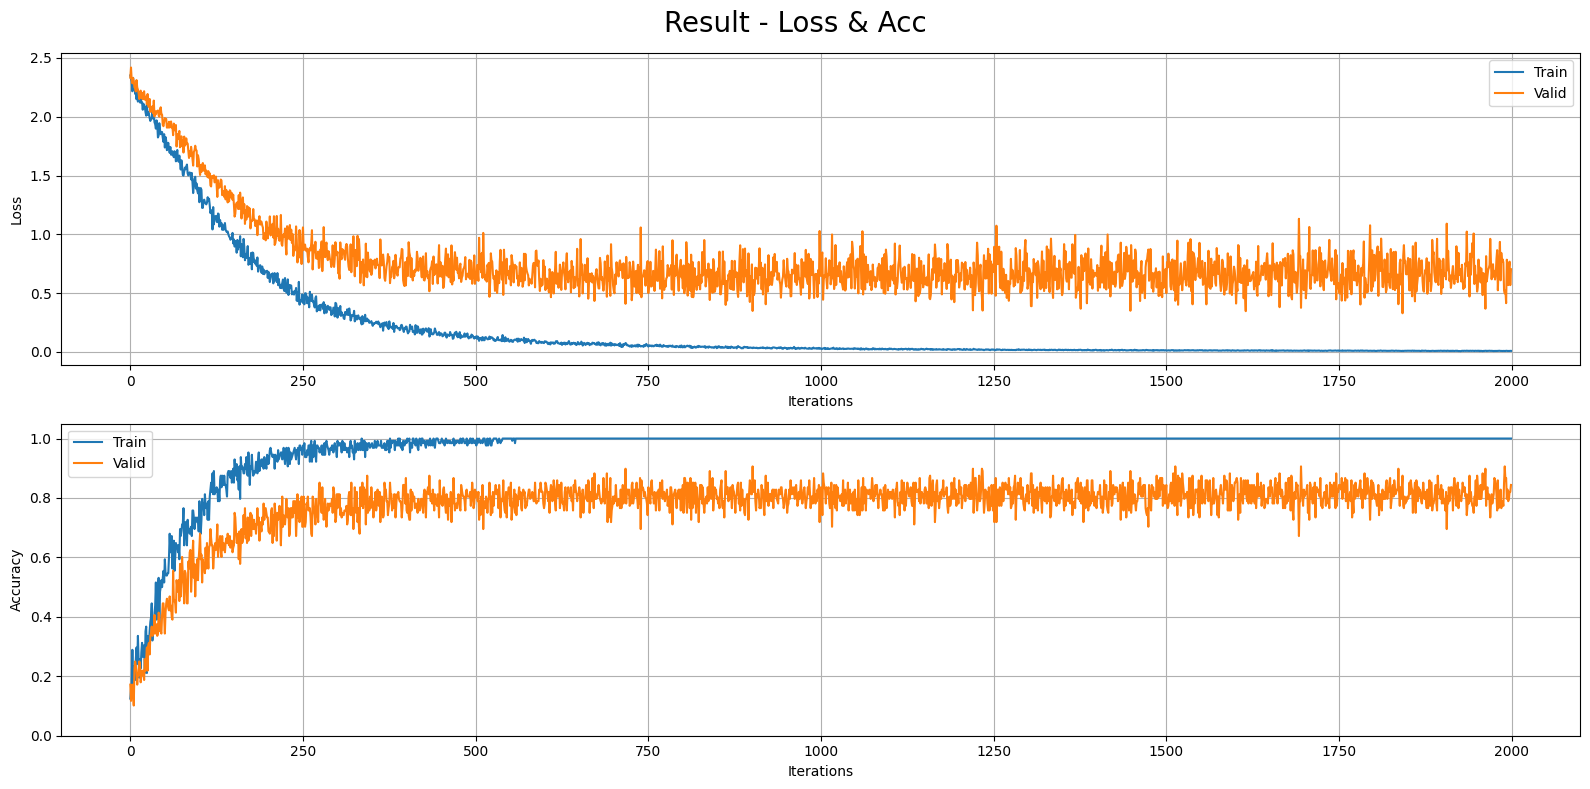

In [25]:
# 모델
model = Net(
    input_size=784,
    hidden_size_list=[100, 100, 100],
    output_size=10,
    use_dropout=False,
    use_batchnorm=False,
    weight_decay_lambda=0,
)

# 옵티마이저
optimizer = SGD(lr=0.01)

# 모델 학습 및 검증 시작
trainer_base = Trainer(
    X_train[:200], y_train[:200], # 과적합을 발생시키기 위해 모델에 비해 데이터셋이 부족하게 설정
    X_valid, y_valid,
    model=model,
    optimizer=optimizer,
    max_iterations=2000,
    batch_size=128,
)
trainer_base.run()

# 결과 시각화
trainer_base.show_results()

## 1. 드롭아웃 (Dropout)

<hr style="height:5px;border:none;color:#5F71F7;background-color:#5F71F7">

```
💡 목차 개요 : 신경망의 과적합을 방지하기 위한 방법 중 하나인 드롭아웃에 대해서 알아보고, 이를 넘파이를 통해 직접 구현해보는 시간을 가집니다.
```

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 드롭아웃 구현하기

In [26]:
# 신경망 학습 중 과적합을 방지하기 위한 Dropout 기법을 구현합니다.
class Dropout:

    # 초기화 함수
    def __init__(self, dropout_ratio=0.5):

        # dropout_ratio: 드롭아웃할 뉴런의 비율
        # e.g., 0.5는 50%의 뉴런을 무작위로 꺼버림
        self.dropout_ratio = dropout_ratio

        # mask: 드롭아웃할 뉴런을 결정하는 불리언 마스크.
        # 이는 오직 학습 시에만 사용됨.
        self.mask = None

    # 순전파 함수
    def forward(self, x, train_flag=True):

        # 학습 시 (train_flag가 True일 때)
        if train_flag:

            # 입력 데이터 x와 동일한 모양의 무작위 배열을 생성하고,
            # dropout_ratio보다 큰 값만 True로 설정
            # 이로써 어떤 뉴런을 꺼버릴지 (False)와 그대로 둘지 (True) 결정됨.
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio

            # mask를 사용해 x의 일부 뉴런을 꺼버림.
            return x * self.mask

        # 테스트 시 (train_flag가 False일 때)
        else:

            # Dropout의 비율만큼 스케일 조정하여 출력
            return x * (1.0 - self.dropout_ratio)

    # 역전파 함수
    def backward(self, dout):

        # mask를 사용하여, 순전파 때 꺼진 뉴런은 그래디언트도 전달되지 않게 함.
        return dout * self.mask

#### 📝 <font color='orange'><b>[ 설명 ]</b></font>
* 학습 시 일부 뉴런을 무작위로 꺼버리는 방식으로 동작합니다. 이로 인해 모델이 특정 뉴런에만 의존하지 않게 되어 과적합을 방지할 수 있습니다.
* 드롭아웃 기법은 학습 중 일부 뉴런을 무작위로 '꺼버려서' 모델이 특정 뉴런들에 지나치게 의존하는 것을 방지합니다. 이를 통해 과적합을 방지할 수 있습니다.
* 마스크는 학습 시 사용되는 불리언 배열로, 어떤 뉴런을 꺼버릴지 결정합니다. True인 뉴런은 활성화 상태를 유지하고, False인 뉴런은 꺼버립니다.
* 테스트 시에는 모든 뉴런을 사용하지만, 출력을 스케일링하여 학습 때 끄게 되는 뉴런의 비율을 반영합니다. 이는 학습 때와 테스트 때의 활성 뉴런 수가 동일하도록 해줍니다.
* 역전파 시에는, 순전파 때 꺼진 뉴런에는 그래디언트가 전달되지 않게 됩니다.

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 위에서 구현한 드롭아웃으로 학습하기

[Elpased Time: 0:00:00.163849] Iter:    0 Train Loss : 2.3269 Train Acc : 0.09 Valid Loss : 2.3054 Valid Acc : 0.12 
[Elpased Time: 0:00:00.648251] Iter:  100 Train Loss : 2.3049 Train Acc : 0.15 Valid Loss : 2.2915 Valid Acc : 0.16 
[Elpased Time: 0:00:01.062925] Iter:  200 Train Loss : 2.2804 Train Acc : 0.09 Valid Loss : 2.2847 Valid Acc : 0.13 
[Elpased Time: 0:00:01.656513] Iter:  300 Train Loss : 2.2756 Train Acc : 0.16 Valid Loss : 2.2750 Valid Acc : 0.17 
[Elpased Time: 0:00:02.114185] Iter:  400 Train Loss : 2.2775 Train Acc : 0.16 Valid Loss : 2.2486 Valid Acc : 0.18 
[Elpased Time: 0:00:02.562401] Iter:  500 Train Loss : 2.2541 Train Acc : 0.12 Valid Loss : 2.2421 Valid Acc : 0.19 
[Elpased Time: 0:00:03.029087] Iter:  600 Train Loss : 2.2385 Train Acc : 0.11 Valid Loss : 2.2471 Valid Acc : 0.10 
[Elpased Time: 0:00:03.497501] Iter:  700 Train Loss : 2.2391 Train Acc : 0.19 Valid Loss : 2.2218 Valid Acc : 0.13 
[Elpased Time: 0:00:03.972734] Iter:  800 Train Loss : 2.1473 Tr

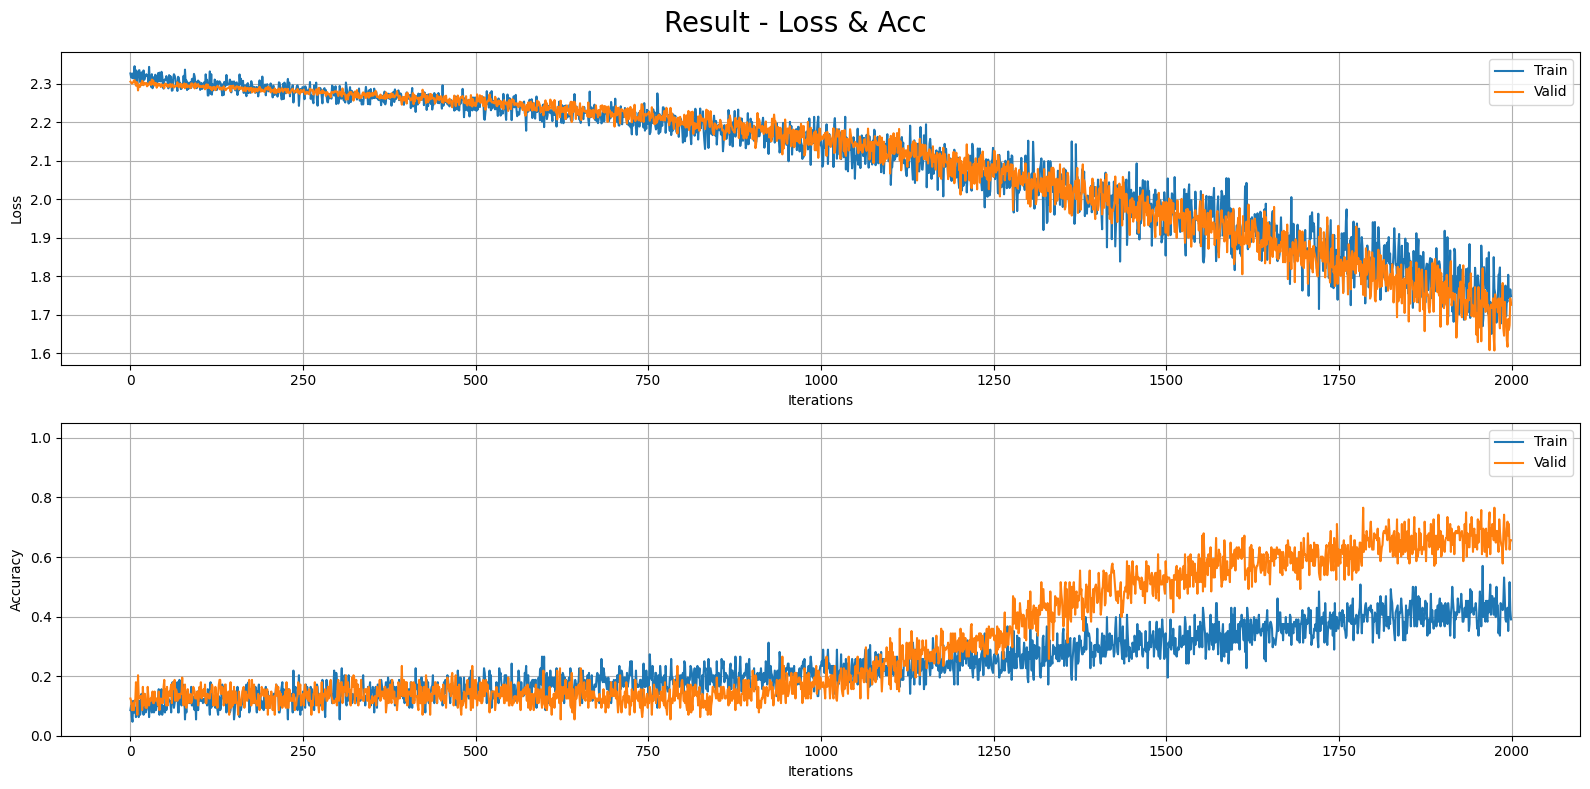

In [27]:
# 모델
model = Net(
    input_size=784,
    hidden_size_list=[100, 100, 100],
    output_size=10,
    use_dropout=True,  # 드롭아웃을 사용해봅시다.
    dropout_ratio=0.5, # 비율을 다양하게 바꿔 실험해봅시다.
)

# 옵티마이저
optimizer = SGD(lr=0.01)

# 모델 학습 및 검증 시작
trainer_dropout = Trainer(
    X_train[:200], y_train[:200], # 과적합을 발생시키기 위해 모델에 비해 데이터셋이 부족하게 설정
    X_valid, y_valid,
    model=model,
    optimizer=optimizer,
    max_iterations=2000,
    batch_size=128,
)
trainer_dropout.run()

# 결과 시각화
trainer_dropout.show_results()

#### 📚 <font color='blue'><b>[ 자료 ]</b></font>

*  [Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: A Simple Way to Prevent Neural Networks from Overfitting. Journal of Machine Learning Research, 15(1), 1929-1958.](http://arxiv.org/abs/1207.0580) : 드롭아웃이 처음 소개되었던 논문입니다. 한 번 살펴보세요.

## 2. 가중치 초기화 (Weight Initialization)

<hr style="height:5px;border:none;color:#5F71F7;background-color:#5F71F7">

```
💡 목차 개요 : 신경망의 과적합을 방지하기 위한 방법 중 하나인 가중치 초기화에 대해서 알아보고, 이를 넘파이를 통해 직접 구현해보는 시간을 가집니다.
```

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 신경망에서 가중치 초기화 파트 살펴보기

```python
class Net:
    def __init__(self,
                 
    # (중략)
                 
    def __init_weight(self, weight_init_std):
        # 전체 네트워크의 각 층의 뉴런 수를 리스트로 구성
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]

        # 모든 층을 순회하며 가중치를 초기화
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std

            # ReLU 활성화 함수를 사용할 경우 He 초기화 방법 사용
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])

            # Sigmoid 활성화 함수를 사용할 경우 Xavier 초기화 방법 사용
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])

            # 가중치와 편향 초기화
            self.params[f'W{idx}'] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params[f'b{idx}'] = np.zeros(all_size_list[idx])

```

#### 📝 <font color='orange'><b>[ 설명 ]</b></font> 가중치 초기화
*  가중치 초기화는 딥 러닝에서 매우 중요합니다. 잘못된 초기화는 학습 속도를 느리게 하거나, 학습이 전혀 이루어지지 않게 할 수 있습니다.
* Xavier 초기화는 활성화 함수로 Sigmoid나 Hyperbolic Tangent를 사용할 때 권장됩니다. 입력 뉴런의 수로 스케일링되어 가중치를 초기화합니다.
* He 초기화는 ReLU와 그 변형을 활성화 함수로 사용할 때 권장됩니다. 입력 뉴런의 수의 절반으로 스케일링되어 가중치를 초기화합니다.

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> Xavier 초기화 방법으로 학습하기

[Elpased Time: 0:00:00.023261] Iter:    0 Train Loss : 2.3040 Train Acc : 0.09 Valid Loss : 2.3004 Valid Acc : 0.11 
[Elpased Time: 0:00:00.583120] Iter:  100 Train Loss : 2.3025 Train Acc : 0.11 Valid Loss : 2.2996 Valid Acc : 0.20 
[Elpased Time: 0:00:01.070774] Iter:  200 Train Loss : 2.2955 Train Acc : 0.18 Valid Loss : 2.2998 Valid Acc : 0.13 
[Elpased Time: 0:00:01.544585] Iter:  300 Train Loss : 2.2940 Train Acc : 0.12 Valid Loss : 2.2980 Valid Acc : 0.08 
[Elpased Time: 0:00:02.042332] Iter:  400 Train Loss : 2.2956 Train Acc : 0.12 Valid Loss : 2.3027 Valid Acc : 0.08 
[Elpased Time: 0:00:02.578342] Iter:  500 Train Loss : 2.2975 Train Acc : 0.12 Valid Loss : 2.2942 Valid Acc : 0.11 
[Elpased Time: 0:00:03.071180] Iter:  600 Train Loss : 2.2962 Train Acc : 0.10 Valid Loss : 2.2999 Valid Acc : 0.10 
[Elpased Time: 0:00:03.593175] Iter:  700 Train Loss : 2.2967 Train Acc : 0.11 Valid Loss : 2.2857 Valid Acc : 0.12 
[Elpased Time: 0:00:04.253805] Iter:  800 Train Loss : 2.2824 Tr

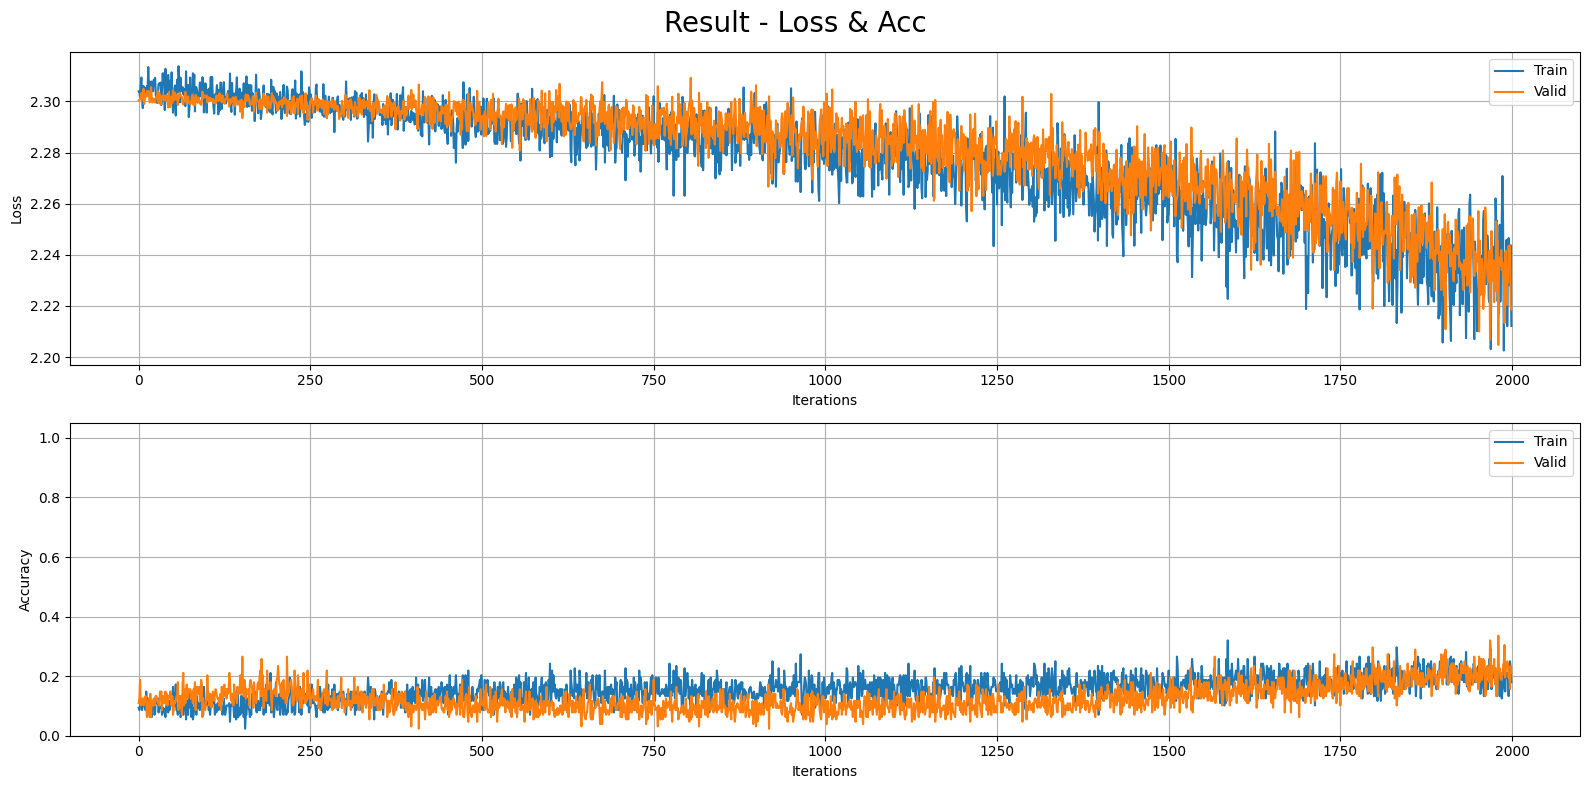

In [28]:
# 모델
model = Net(
    input_size=784,
    hidden_size_list=[100, 100, 100],
    output_size=10,
    use_dropout=True,
    dropout_ratio=0.5,
    weight_init_std='xavier',
    activation='relu',  # sigmoid 였다면 다를까요?
)

# 옵티마이저
optimizer = SGD(lr=0.01)

# 모델 학습 및 검증 시작
trainer_xavier = Trainer(
    X_train[:200], y_train[:200], # 과적합을 발생시키기 위해 모델에 비해 데이터셋이 부족하게 설정
    X_valid, y_valid,
    model=model,
    optimizer=optimizer,
    max_iterations=2000,
    batch_size=128,
)
trainer_xavier.run()

# 결과 시각화
trainer_xavier.show_results()

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> He 초기화 방법으로 학습하기

[Elpased Time: 0:00:00.074504] Iter:    0 Train Loss : 2.3311 Train Acc : 0.08 Valid Loss : 2.3073 Valid Acc : 0.08 
[Elpased Time: 0:00:00.551315] Iter:  100 Train Loss : 2.2923 Train Acc : 0.09 Valid Loss : 2.2992 Valid Acc : 0.10 
[Elpased Time: 0:00:02.555603] Iter:  200 Train Loss : 2.2901 Train Acc : 0.12 Valid Loss : 2.2907 Valid Acc : 0.16 
[Elpased Time: 0:00:03.074265] Iter:  300 Train Loss : 2.2891 Train Acc : 0.14 Valid Loss : 2.2811 Valid Acc : 0.18 
[Elpased Time: 0:00:03.704057] Iter:  400 Train Loss : 2.2626 Train Acc : 0.14 Valid Loss : 2.2739 Valid Acc : 0.19 
[Elpased Time: 0:00:04.221982] Iter:  500 Train Loss : 2.2691 Train Acc : 0.20 Valid Loss : 2.2638 Valid Acc : 0.16 
[Elpased Time: 0:00:04.727406] Iter:  600 Train Loss : 2.2429 Train Acc : 0.19 Valid Loss : 2.2601 Valid Acc : 0.18 
[Elpased Time: 0:00:05.445065] Iter:  700 Train Loss : 2.2479 Train Acc : 0.20 Valid Loss : 2.2466 Valid Acc : 0.23 
[Elpased Time: 0:00:06.043804] Iter:  800 Train Loss : 2.2158 Tr

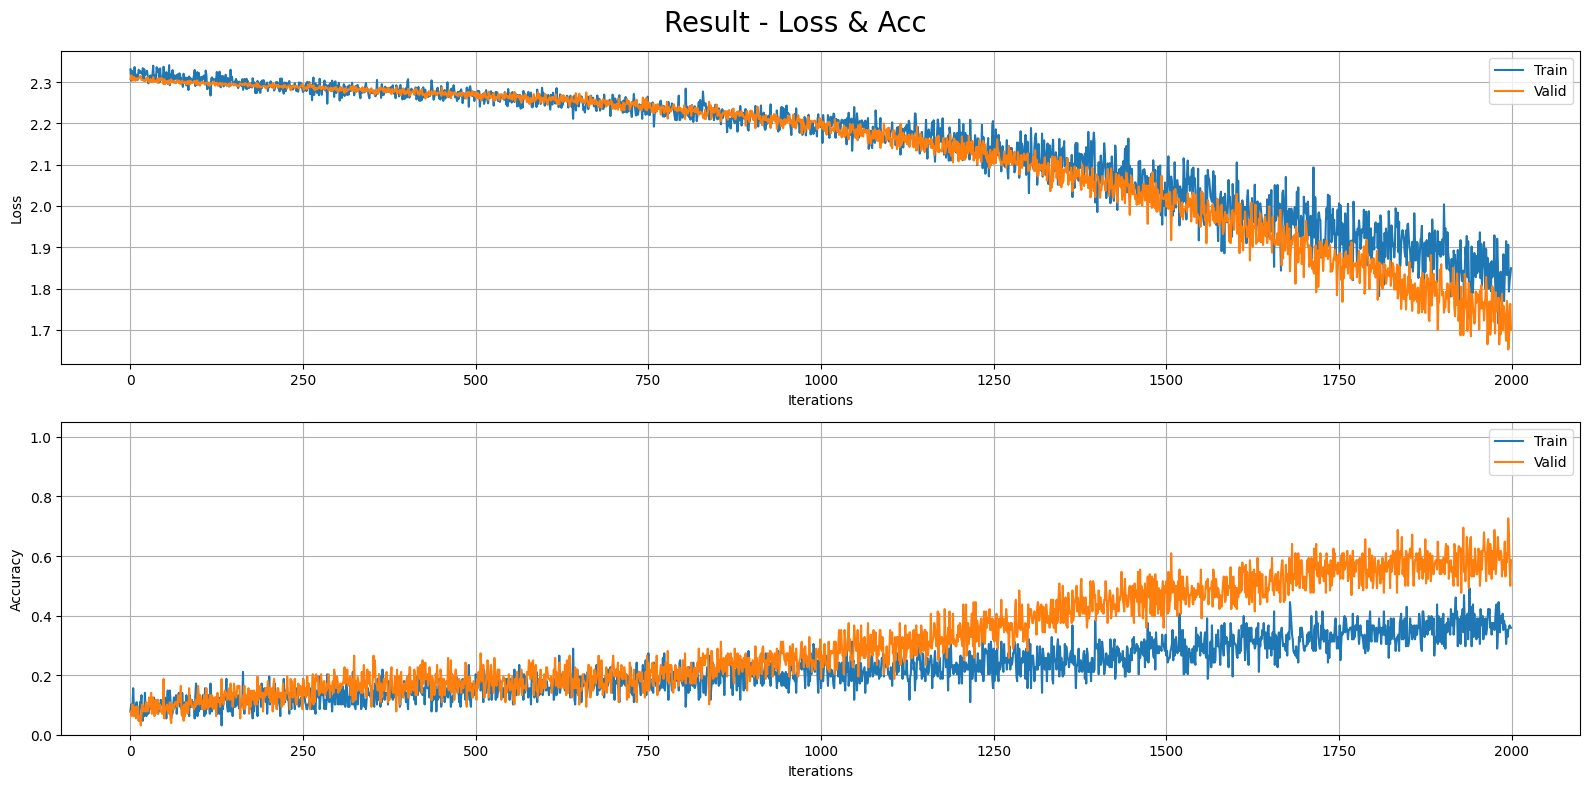

In [29]:
# 모델
model = Net(
    input_size=784,
    hidden_size_list=[100, 100, 100],
    output_size=10,
    use_dropout=True,
    dropout_ratio=0.5,
    weight_init_std='he',
    activation='relu', # sigmoid 였다면 다를까요?
)

# 옵티마이저
optimizer = SGD(lr=0.01)

# 모델 학습 및 검증 시작
trainer_he = Trainer(
    X_train[:200], y_train[:200], # 과적합을 발생시키기 위해 모델에 비해 데이터셋이 부족하게 설정
    X_valid, y_valid,
    model=model,
    optimizer=optimizer,
    max_iterations=2000,
    batch_size=128,
)
trainer_he.run()

# 결과 시각화
trainer_he.show_results()

#### 📚 <font color='blue'><b>[ 자료 ]</b></font>

* [Glorot, X., & Bengio, Y. (2010). Understanding the difficulty of training deep feedforward neural networks.](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) : Xavier 초기화 방법을 제안한 원본 논문입니다. 한 번 살펴보세요.
* [He, K., Zhang, X., Ren, S., & Sun, J. (2015). Delving deep into rectifiers: Surpassing human-level performance on imagenet classification.](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf) : He 초기화 방법을 제안한 원본 논문입니다. ReLU 활성화 함수를 사용할 때 가중치를 초기화하는 방법을 설명합니다.
* [CS231n 강의노트의 Weight Initialization 부분](http://cs231n.github.io/neural-networks-2/#init) : 가중치 초기화의 중요성과 다양한 초기화 방법을 이해하기 쉽게 설명합니다.

## 3. 배치 정규화 (Batch Normalization)

<hr style="height:5px;border:none;color:#5F71F7;background-color:#5F71F7">

```
💡 목차 개요 : 신경망의 과적합을 방지하기 위한 방법 중 하나인 배치 정규화에 대해서 알아보고, 이를 넘파이를 통해 직접 구현해보는 시간을 가집니다.
```

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 배치 정규화 구현하기

In [30]:
# BatchNormalization 클래스: 신경망의 학습을 안정화하고 가속화하는 Batch Normalization 기법을 구현합니다.
class BatchNormalization:

    # 초기화 함수
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):

        # gamma, beta: 학습 가능한 스케일 및 시프트 파라미터
        self.gamma = gamma
        self.beta = beta

        # momentum: 평균 및 분산의 움직이는 평균을 계산할 때 사용되는 모멘텀 값
        self.momentum = momentum

        # 입력 데이터의 형태를 저장 (예: (batch_size, features))
        self.input_shape = None

        # 학습 중 아닌 상황(예: 평가)에서 사용할 실행 중 평균 및 분산
        self.running_mean = running_mean
        self.running_var = running_var

        # 역전파 시 사용될 중간 값들
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    # 순전파 함수
    def forward(self, x, train_flag=True):
        self.input_shape = x.shape

        # 4D 텐서인 경우 2D로 변경
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        # running_mean 및 running_var 초기화
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)

        # 학습 시
        if train_flag:

            # 현재 배치의 평균 및 분산 계산
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std

            # 중간 값들 저장
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std

            # 실행 중 평균 및 분산 업데이트
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var

        # 평가 시
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))

        # 최종 출력 계산
        out = self.gamma * xn + self.beta

        return out.reshape(*self.input_shape)

    # 역전파 함수
    def backward(self, dout):

        # 4D 텐서인 경우 2D로 변경
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        # 역전파 계산을 위한 그래디언트들
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size

        # 학습 가능한 파라미터들의 그래디언트 저장
        self.dgamma = dgamma
        self.dbeta = dbeta

        return dx.reshape(*self.input_shape)


#### 📝 <font color='orange'><b>[ 설명 ]</b></font>
* 배치 정규화는 심층 신경망의 내부에서 활성화값이 특정 분포를 유지하도록 도와 학습을 안정화하고 속도를 빠르게 하는 기법입니다.
* 기본 아이디어는 네트워크의 각 층의 활성화값이 너무 크거나 작게 되지 않도록 조정함으로써, 네트워크의 학습을 보다 빠르고 안정적으로 만드는 것입니다.
* 학습 시에는 현재 배치의 평균과 분산을 계산하여 정규화를 수행하고, 평가 시에는 학습 동안의 움직이는 평균과 분산을 사용하여 정규화합니다.
* `running_mean` 및 `running_var` (즉, 이동 평균과 분산)은 학습 중 배치 정규화의 안정성과 테스트 시의 일관성을 위해 도입되었습니다. 그러나 그것들이 항상 필요하다고는 할 수 없습니다. 필요성은 여러 상황에 따라 달라집니다. `running_mean`과 `running_var` 사용하면, 모델이 학습 중과 테스트 중에 동일한 방식으로 동작하는 것을 보장할 수 있습니다.
* 테스트나 추론(inference) 시에는 종종 배치 크기가 1이거나 예측하려는 샘플 수에 따라 다양합니다. 이 경우 각 샘플 또는 작은 배치의 평균과 분산을 계산하는 것은 불안정할 수 있습니다. 이 때 `running_mean`과 `running_var` 학습 중에 축적된 평균적인 정보를 제공하여 추론을 안정화합니다. 물론, 특정 상황에서는 `running_mean`과 `running_var` 없이도 잘 작동하는 경우도 있습니다. 예를 들어, 배치 크기가 충분히 크고 데이터의 분포가 학습 데이터와 테스트 데이터에서 크게 달라지지 않는 경우에는 꼭 필요하지 않을 수 있습니다. 결론적으로, 이동 평균과 분산을 사용하는 것은 일반적인 권장 사항이지만, 항상 필요한 것은 아닙니다. 실험과 실험의 결과에 따라 최적의 방법을 결정하는 것이 좋습니다.

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 위에서 구현한 배치 정규화로 학습하기

[Elpased Time: 0:00:00.008249] Iter:    0 Train Loss : 2.5293 Train Acc : 0.09 Valid Loss : 2.4250 Valid Acc : 0.11 
[Elpased Time: 0:00:00.497864] Iter:  100 Train Loss : 2.2727 Train Acc : 0.19 Valid Loss : 2.0747 Valid Acc : 0.34 
[Elpased Time: 0:00:01.212275] Iter:  200 Train Loss : 2.1356 Train Acc : 0.23 Valid Loss : 1.8063 Valid Acc : 0.47 
[Elpased Time: 0:00:01.959427] Iter:  300 Train Loss : 1.9441 Train Acc : 0.32 Valid Loss : 1.6512 Valid Acc : 0.55 
[Elpased Time: 0:00:02.803312] Iter:  400 Train Loss : 1.8230 Train Acc : 0.35 Valid Loss : 1.5580 Valid Acc : 0.61 
[Elpased Time: 0:00:03.349621] Iter:  500 Train Loss : 1.7601 Train Acc : 0.45 Valid Loss : 1.4228 Valid Acc : 0.64 
[Elpased Time: 0:00:03.970320] Iter:  600 Train Loss : 1.6934 Train Acc : 0.44 Valid Loss : 1.2371 Valid Acc : 0.69 
[Elpased Time: 0:00:04.996806] Iter:  700 Train Loss : 1.5157 Train Acc : 0.55 Valid Loss : 1.1810 Valid Acc : 0.72 
[Elpased Time: 0:00:05.919441] Iter:  800 Train Loss : 1.4889 Tr

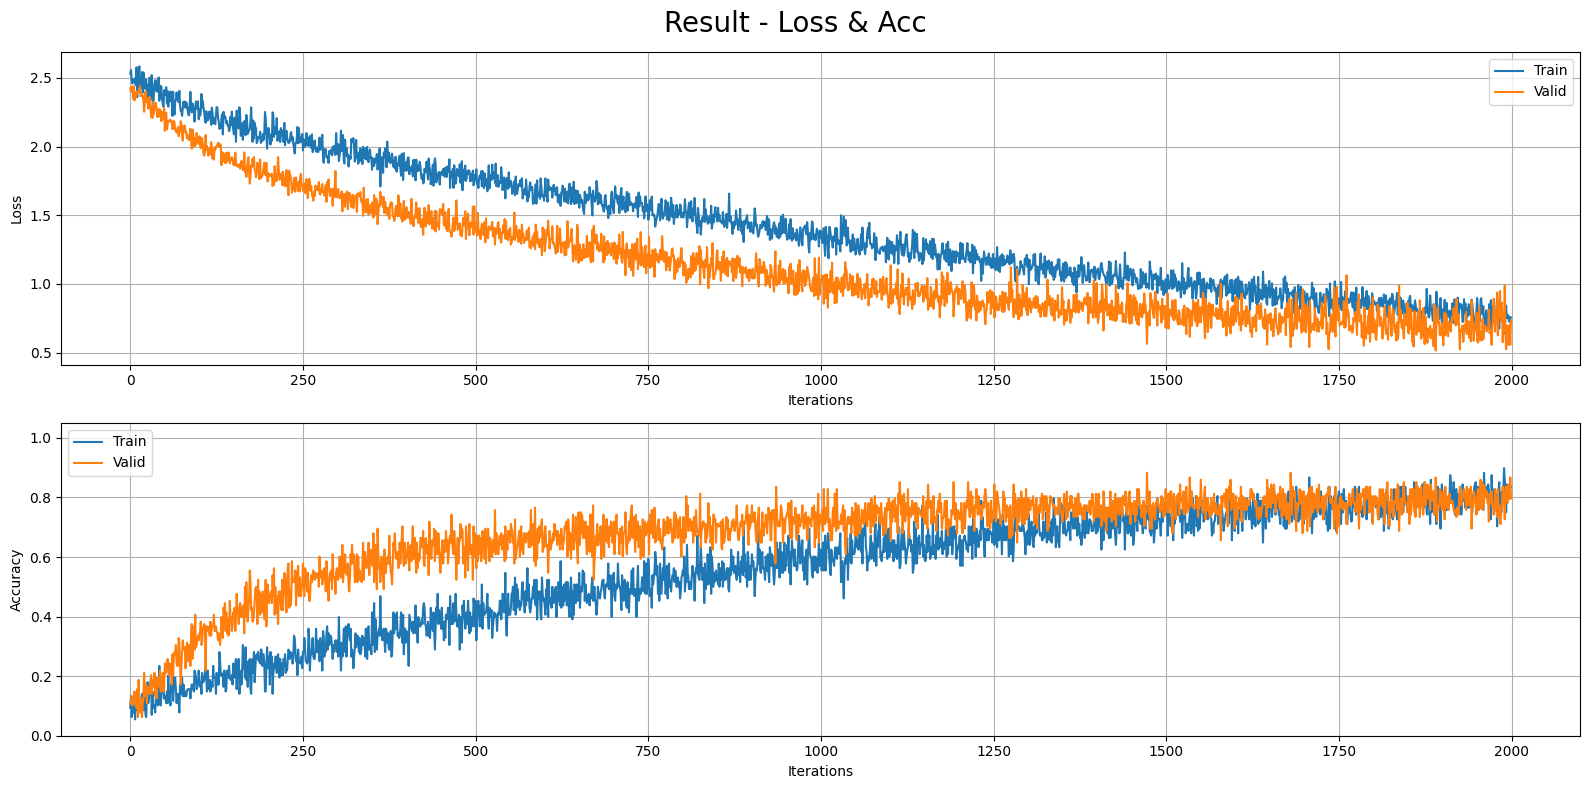

In [31]:
# 모델
model = Net(
    input_size=784,
    hidden_size_list=[100, 100, 100],
    output_size=10,
    weight_init_std='he',
    use_dropout=True,
    dropout_ratio=0.5,
    use_batchnorm=True,  # 이번에는 배치 정규화를 사용해볼까요?
)

# 옵티마이저
optimizer = SGD(lr=0.01)

# 모델 학습 및 검증 시작
trainer_batchnorm = Trainer(
    X_train[:200], y_train[:200], # 과적합을 발생시키기 위해 모델에 비해 데이터셋이 부족하게 설정
    X_valid, y_valid,
    model=model,
    optimizer=optimizer,
    max_iterations=2000,
    batch_size=128,
)
trainer_batchnorm.run()

# 결과 시각화
trainer_batchnorm.show_results()

#### 📚 <font color='blue'><b>[ 자료 ]</b></font>

*  [Ioffe, S., & Szegedy, C. (2015). Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift.](https://arxiv.org/abs/1502.03167) : 배치 정규화가 처음 소개되었던 논문입니다. 한 번 살펴보세요.

#### 📝 <font color='orange'><b>[ 설명 ]</b></font> 드롭아웃, 가중치 초기화 그리고 배치 정규화 성능 비교하기

점점 성능 최적화 기법이 적용되면서 어떻게 성능이 변화하는지 한꺼번에 살펴볼까요? 비교를 위해서 검증 데이터의 오차를 비교해보겠습니다. 드롭아웃만 활용했을 경우보다, 가중치 초기화와 배치 정규화를 활용하는 경우가 더욱 오차가 확연히 줄어든 것을 확인할 수 있습니다.

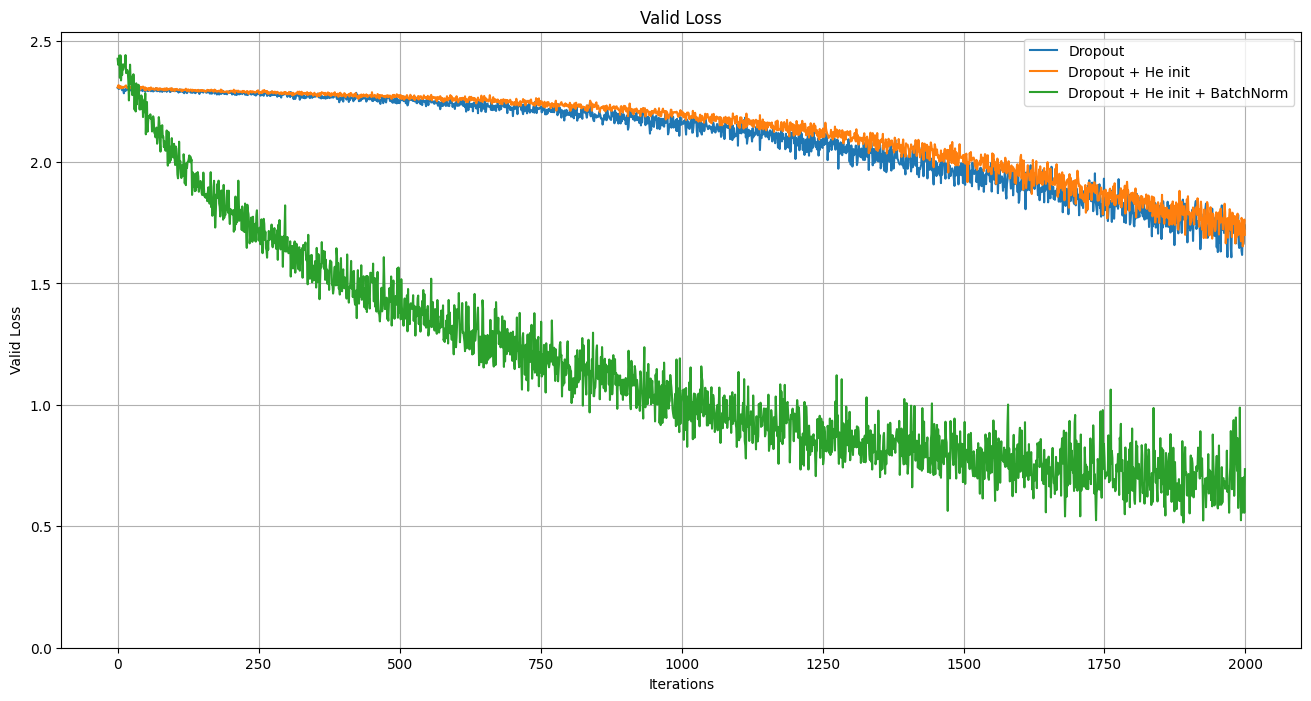

In [32]:
plt.figure(figsize=(16,8))

plt.plot(trainer_dropout.valid_loss_list)
plt.plot(trainer_he.valid_loss_list)
plt.plot(trainer_batchnorm.valid_loss_list)

plt.xlabel('Iterations')
plt.ylabel('Valid Loss')
plt.legend(['Dropout', 'Dropout + He init', 'Dropout + He init + BatchNorm'])
plt.ylim(0,)

plt.title('Valid Loss')
plt.grid(True)
plt.show()

손실 오차 뿐만 아니라 정확도도 점점 좋아지는 걸 확인할 수 있습니다.

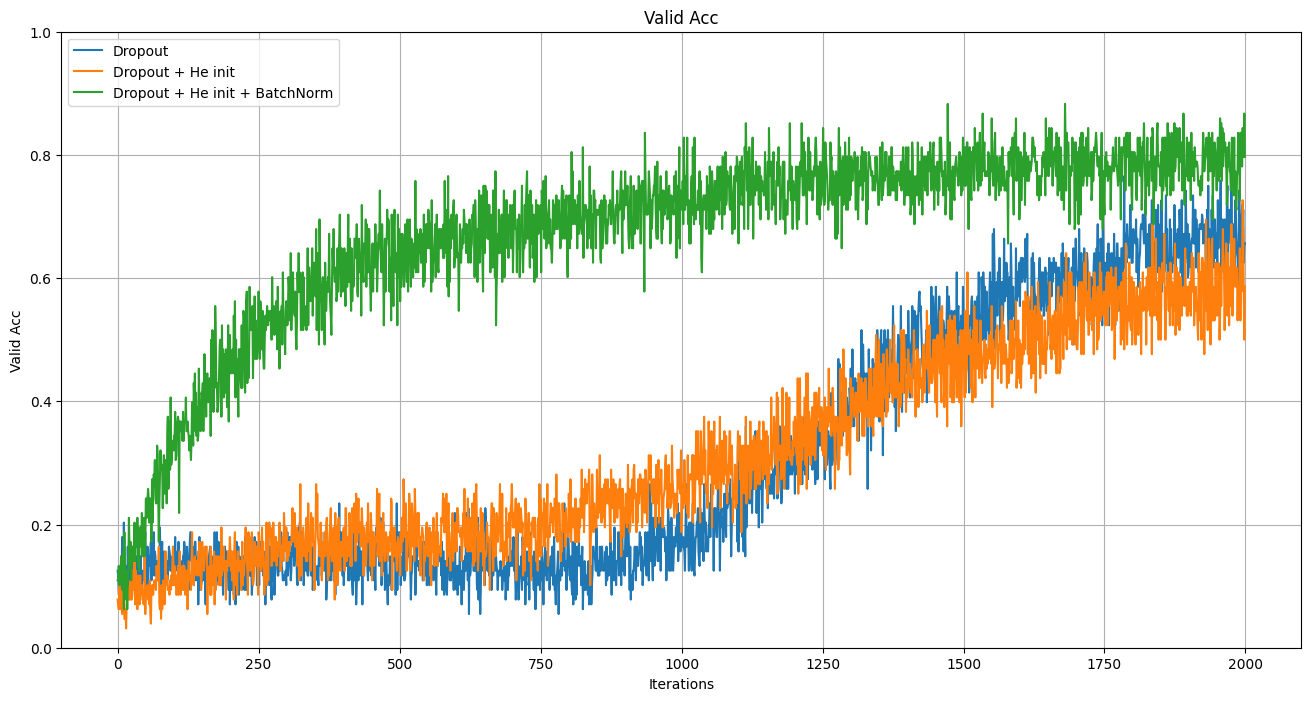

In [33]:
plt.figure(figsize=(16,8))

plt.plot(trainer_dropout.valid_acc_list)
plt.plot(trainer_he.valid_acc_list)
plt.plot(trainer_batchnorm.valid_acc_list)

plt.xlabel('Iterations')
plt.ylabel('Valid Acc')
plt.legend(['Dropout', 'Dropout + He init', 'Dropout + He init + BatchNorm'])
plt.ylim(0,1)

plt.title('Valid Acc')
plt.grid(True)
plt.show()

## 4. 딥러닝에서의 다양한 옵티마이저(Optimizer)

<hr style="height:5px;border:none;color:#5F71F7;background-color:#5F71F7">

```
💡 목차 개요 : 신경망의 가중치를 업데이트하는 다양한 방법들에 대해서 알아보고, 각 알고리즘을 넘파이로 구현해보는 시간을 갖습니다.
```

- 4-1. SGD 이해 및 구현
- 4-2. Momentum 이해 및 구현
- 4-3. Nesterov 이해 및 구현
- 4-4. AdaGrad 이해 및 구현
- 4-5. RMSProp 이해 및 구현
- 4-6. Adam 이해 및 구현

### 4-1. SGD

> 세부 목차 개요 : SGD는 딥러닝에서 사용되는 기본적인 옵티마이저입니다. 주어진 파라미터의 기울기($\frac{\partial L}{\partial W}$)에 따라 해당 파라미터 값을 업데이트하는 방식으로 동작합니다. 학습률($\eta$)은 이 업데이트의 크기를 조절하는 중요한 파라미터로, 적절한 값을 선택하는 것이 중요합니다.

$$ W \leftarrow W - \eta\frac{\partial L}{\partial W} $$


#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> SGD 구현하기

```python
class SGD:

    # 학습률(learning rate)를 설정합니다.
    def __init__(self, lr=0.01):
        self.lr = lr  # 학습률 설정

    # 파라미터를 업데이트하는 함수
    def update(self, params, grads):
        
        # 각 파라미터에 대해
        for key in params.keys():
            
            # 파라미터 값을 기울기 방향으로 학습률만큼 업데이트합니다.
            params[key] -= self.lr * grads[key]
```

#### 📝 <font color='orange'><b>[ 설명 ]</b></font>
* 한 번의 업데이트에 하나의 데이터 또는 미니배치를 사용합니다.
* SGD는 각 업데이트마다 다른 데이터 또는 미니배치를 사용하므로 "확률적"이라는 이름이 붙습니다.
* 기본적인 방식이기 때문에 다른 최적화 알고리즘보다 수렴 속도가 느릴 수 있습니다.
* 각 파라미터(가중치 및 편향)의 기울기(gradient)를 계산합니다.
* 파라미터를 기울기의 반대 방향으로 학습률만큼 조정하여 신경망의 오차를 줄입니다.

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 위에서 구현한 SGD 옵티마이저로 학습하기

[Elpased Time: 0:00:00.089468] Iter:    0 Train Loss : 2.5345 Train Acc : 0.09 Valid Loss : 2.4239 Valid Acc : 0.14 
[Elpased Time: 0:00:00.944144] Iter:  100 Train Loss : 2.4371 Train Acc : 0.11 Valid Loss : 2.1510 Valid Acc : 0.23 
[Elpased Time: 0:00:01.689049] Iter:  200 Train Loss : 2.2730 Train Acc : 0.21 Valid Loss : 1.8596 Valid Acc : 0.48 
[Elpased Time: 0:00:02.481330] Iter:  300 Train Loss : 2.1582 Train Acc : 0.24 Valid Loss : 1.7144 Valid Acc : 0.60 
[Elpased Time: 0:00:03.005996] Iter:  400 Train Loss : 2.1032 Train Acc : 0.23 Valid Loss : 1.6196 Valid Acc : 0.70 
[Elpased Time: 0:00:04.011003] Iter:  500 Train Loss : 1.9634 Train Acc : 0.34 Valid Loss : 1.4550 Valid Acc : 0.73 
[Elpased Time: 0:00:04.888726] Iter:  600 Train Loss : 1.9218 Train Acc : 0.31 Valid Loss : 1.4525 Valid Acc : 0.69 
[Elpased Time: 0:00:05.765765] Iter:  700 Train Loss : 1.9524 Train Acc : 0.36 Valid Loss : 1.3540 Valid Acc : 0.72 
[Elpased Time: 0:00:06.299510] Iter:  800 Train Loss : 1.8055 Tr

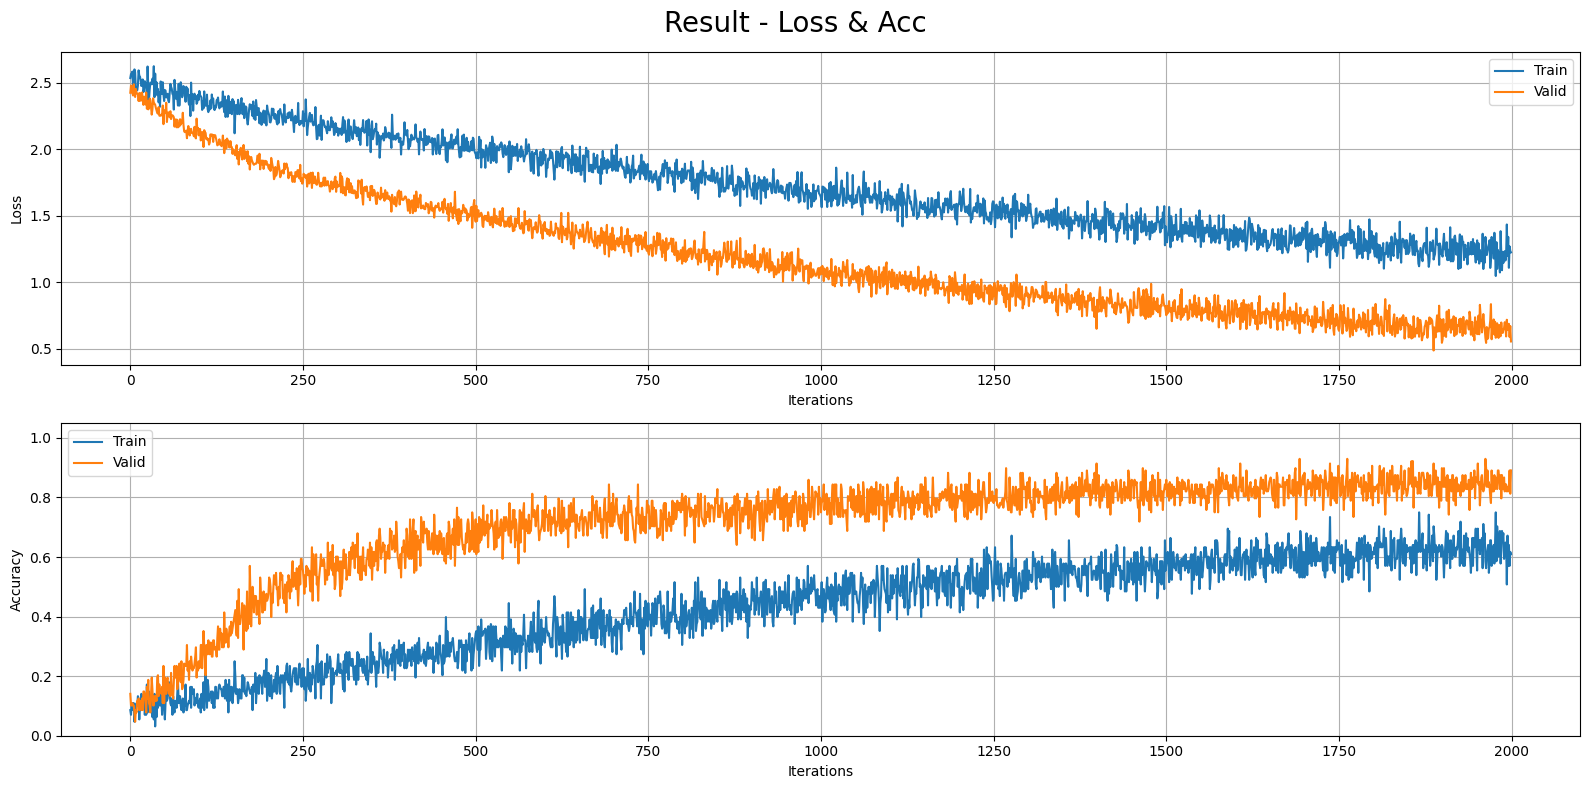

In [34]:
# 모델
model = Net(
    input_size=784,
    hidden_size_list=[100, 100, 100],
    output_size=10,
    use_batchnorm=True,
    weight_init_std='he',
    use_dropout=True,
    dropout_ratio=0.5,
)

# 옵티마이저
optimizer = SGD(lr=0.01)

# 모델 학습 및 검증 시작
trainer_sgd = Trainer(
    X_train, y_train,
    X_valid, y_valid,
    model=model,
    optimizer=optimizer,
    max_iterations=2000,
    batch_size=128,
)
trainer_sgd.run()

# 결과 시각화
trainer_sgd.show_results()

#### 📚 <font color='blue'><b>[ 자료 ]</b></font>
* ["Deep Learning" by Goodfellow, Bengio, and Courville]() : 심층 학습에 대한 권위있는 교재로, SGD와 다른 최적화 방법들에 대한 자세한 설명이 있습니다.
* [CS231n 강의노트의 Optimization 부분](http://cs231n.github.io/neural-networks-3/#update) : SGD와 다른 최적화 방법들을 비교하며 각각의 장단점에 대해 설명합니다.

### 4-2. 모멘텀 (Momentum)

> 세부 목차 개요 : 모멘텀은 "운동량" 개념을 SGD에 추가하여 파라미터 업데이트의 방향성을 강화하고, 수렴 속도를 개선하는 옵티마이저입니다. 기존의 기울기 정보($v$)와 현재 기울기 정보($\frac{\partial L}{\partial W}$)를 모두 활용하여 파라미터를 업데이트합니다.

$$ v \leftarrow \alpha v - \eta \frac{\partial L}{\partial W} $$

$$ W \leftarrow W + v $$

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 모멘텀 구현하기

In [35]:
class Momentum:

    # 생성자: 학습률(learning rate) 및 모멘텀 값 설정
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr                 # 학습률 설정
        self.momentum = momentum     # 모멘텀 설정
        self.v = None                # 속도 초기화

    # 파라미터 업데이트 함수
    def update(self, params, grads):

        # 첫 번째 호출 시 속도(v)를 파라미터와 동일한 형상의 0으로 초기화
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        # 모든 파라미터에 대해
        for key in params.keys():

            # 속도 업데이트
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]

            # 파라미터 업데이트
            params[key] += self.v[key]


#### 📝 <font color='orange'><b>[ 설명 ]</b></font>
*  속도(v)는 과거의 기울기를 어느 정도 기억하면서 업데이트에 활용됩니다.
* 이로 인해 기울기가 지속적으로 같은 방향으로 움직이면, 그 방향으로 가속도가 붙게 됩니다. 반대로, 기울기가 방향을 바꾸면 속도는 감소합니다.
* 이러한 동작으로 인해 모멘텀은 SGD보다 더 빠르게 수렴하며, 지역 최솟값(local minima)에서 벗어나는 데도 효과적입니다.
* 파라미터의 기울기에 학습률을 곱한 값을 현재 속도에 더하고, 이 값을 파라미터에서 뺍니다.
* v는 현재 기울기와 이전 단계에서의 속도를 모두 고려하여 파라미터를 얼마나 업데이트할지 결정하는데 사용됩니다.
* 모멘텀 값은 이전 단계의 속도에 대한 가중치로, [0, 1] 사이의 값을 가집니다. 일반적으로 0.9와 같은 높은 값을 사용합니다.

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 위에서 구현한 모멘텀 옵티마이저로 학습하기


[Elpased Time: 0:00:00.008018] Iter:    0 Train Loss : 2.3947 Train Acc : 0.11 Valid Loss : 2.4137 Valid Acc : 0.09 
[Elpased Time: 0:00:01.486243] Iter:  100 Train Loss : 1.6984 Train Acc : 0.43 Valid Loss : 1.1045 Valid Acc : 0.72 
[Elpased Time: 0:00:02.328740] Iter:  200 Train Loss : 1.2369 Train Acc : 0.59 Valid Loss : 0.7000 Valid Acc : 0.80 
[Elpased Time: 0:00:03.322576] Iter:  300 Train Loss : 1.0588 Train Acc : 0.72 Valid Loss : 0.5113 Valid Acc : 0.86 
[Elpased Time: 0:00:04.348754] Iter:  400 Train Loss : 0.9063 Train Acc : 0.71 Valid Loss : 0.3604 Valid Acc : 0.91 
[Elpased Time: 0:00:05.474470] Iter:  500 Train Loss : 0.7691 Train Acc : 0.81 Valid Loss : 0.4069 Valid Acc : 0.88 
[Elpased Time: 0:00:06.208229] Iter:  600 Train Loss : 0.7897 Train Acc : 0.76 Valid Loss : 0.4261 Valid Acc : 0.87 
[Elpased Time: 0:00:06.933540] Iter:  700 Train Loss : 0.7079 Train Acc : 0.79 Valid Loss : 0.3559 Valid Acc : 0.88 
[Elpased Time: 0:00:07.661956] Iter:  800 Train Loss : 0.7220 Tr

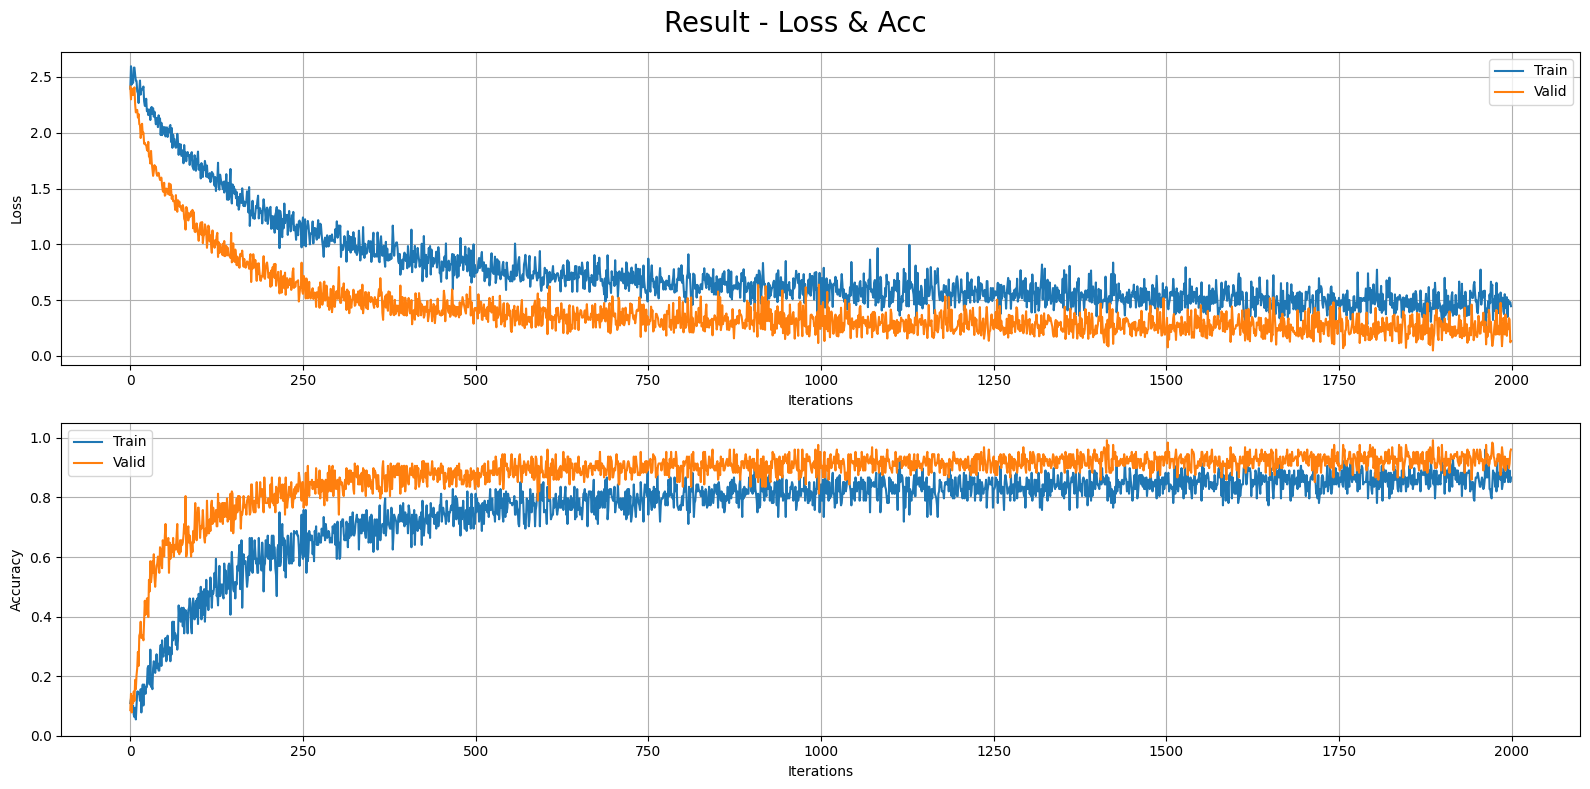

In [36]:
# 모델
model = Net(
    input_size=784,
    hidden_size_list=[100, 100, 100],
    output_size=10,
    use_batchnorm=True,
    weight_init_std='he',
    use_dropout=True,
    dropout_ratio=0.5,
)

# 옵티마이저
optimizer = Momentum(lr=0.01, momentum=0.9)

# 모델 학습 및 검증 시작
trainer_momentum = Trainer(
    X_train, y_train,
    X_valid, y_valid,
    model=model,
    optimizer=optimizer,
    max_iterations=2000,
    batch_size=128,
)
trainer_momentum.run()

# 결과 시각화
trainer_momentum.show_results()

#### 📚 <font color='blue'><b>[ 자료 ]</b></font>
* ["Deep Learning" by Goodfellow, Bengio, and Courville]() : 심층 학습에 대한 권위있는 교재로, SGD와 다른 최적화 방법들에 대한 자세한 설명이 있습니다.
* [CS231n 강의노트의 Optimization 부분](http://cs231n.github.io/neural-networks-3/#update) : SGD와 다른 최적화 방법들을 비교하며 각각의 장단점에 대해 설명합니다.

### 4-3. Nesterov

> 세부 목차 개요 : Nesterov Accelerated Gradient (NAG)는 모멘텀 방식을 향상시킨 최적화 방법입니다. 기본 아이디어는 "미리보기"를 사용하여 미래의 파라미터 위치에서의 기울기를 계산하고 이를 사용하여 파라미터를 업데이트하는 것입니다. 이로 인해, 최적화 과정이 더 부드럽게 이루어지며 수렴 속도가 개선됩니다.

$$ v \leftarrow \alpha v - \eta \frac{\partial L}{\partial W}(W + \alpha v)$$

$$ W \leftarrow W + v $$

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> Nesterov 구현하기

In [37]:
class Nesterov:

    # 학습률(learning rate) 및 모멘텀 계수 설정
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr             # 학습률
        self.momentum = momentum # 모멘텀 계수
        self.v = None            # 속도

    # 파라미터 업데이트 함수
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        # 각 파라미터에 대해
        for key in params.keys():

            # 현재 속도를 기반으로 예측된 위치 계산
            w_pred = params[key] + self.momentum * self.v[key]

            # 예측된 위치에서의 그래디언트 계산
            # 여기서는 간단하게 현재 위치에서의 그래디언트를 사용합니다.
            g = grads[key]

            # 속도 업데이트
            self.v[key] = self.momentum * self.v[key] - self.lr * g

            # 파라미터 업데이트
            params[key] += self.v[key]

#### 📝 <font color='orange'><b>[ 설명 ]</b></font>
* 기본 아이디어는 파라미터가 업데이트될 방향을 "미리 살펴보는" 것입니다.
* 다시 말해, 모멘텀에 따라 미래의 파라미터 위치를 "예측"하고 그 위치에서의 기울기를 사용하여 파라미터를 업데이트합니다.
* Nesterov 모멘텀은 먼저 모멘텀만으로 파라미터를 임시로 이동시키고 (이동된 임시 위치를 "미리보기" 위치로 생각할 수 있음), 이동된 위치에서의 기울기를 계산하여 파라미터를 업데이트합니다.
* 이 방식은 파라미터 업데이트가 더 부드럽게 이루어지도록 도와줍니다.

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 위에서 구현한 Nesterov 옵티마이저로 학습하기


[Elpased Time: 0:00:00.022132] Iter:    0 Train Loss : 2.4911 Train Acc : 0.12 Valid Loss : 2.4548 Valid Acc : 0.07 
[Elpased Time: 0:00:00.570087] Iter:  100 Train Loss : 1.6711 Train Acc : 0.44 Valid Loss : 1.1579 Valid Acc : 0.70 
[Elpased Time: 0:00:01.688847] Iter:  200 Train Loss : 1.2389 Train Acc : 0.64 Valid Loss : 0.6608 Valid Acc : 0.86 
[Elpased Time: 0:00:02.477389] Iter:  300 Train Loss : 0.9578 Train Acc : 0.72 Valid Loss : 0.5078 Valid Acc : 0.85 
[Elpased Time: 0:00:03.187052] Iter:  400 Train Loss : 0.7672 Train Acc : 0.80 Valid Loss : 0.3160 Valid Acc : 0.91 
[Elpased Time: 0:00:04.117529] Iter:  500 Train Loss : 0.9225 Train Acc : 0.69 Valid Loss : 0.2790 Valid Acc : 0.93 
[Elpased Time: 0:00:04.896237] Iter:  600 Train Loss : 0.7004 Train Acc : 0.76 Valid Loss : 0.2887 Valid Acc : 0.93 
[Elpased Time: 0:00:05.596020] Iter:  700 Train Loss : 0.7479 Train Acc : 0.82 Valid Loss : 0.2812 Valid Acc : 0.92 
[Elpased Time: 0:00:06.326657] Iter:  800 Train Loss : 0.6326 Tr

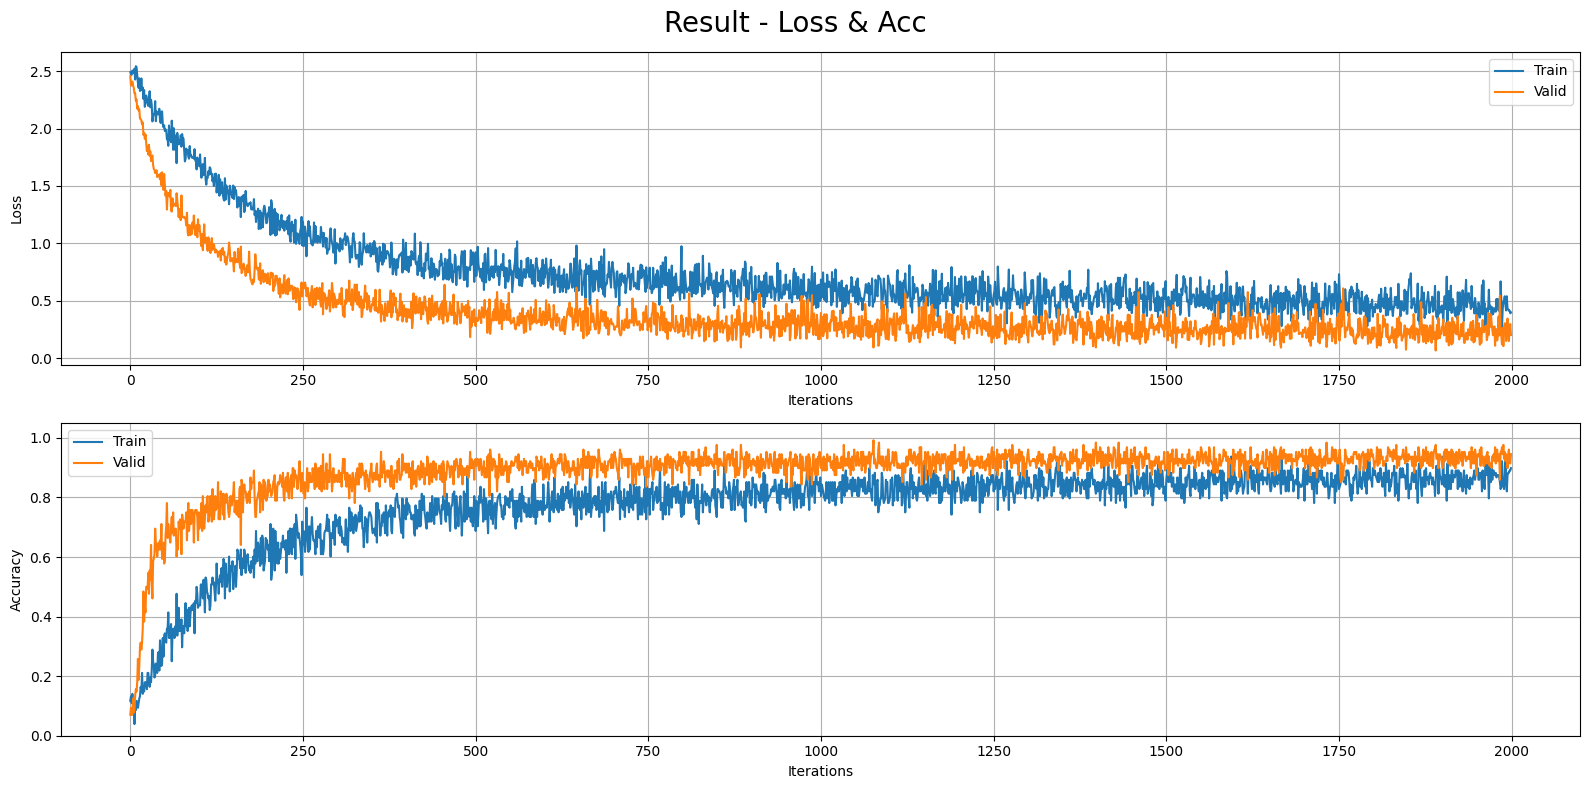

In [38]:
# 모델
model = Net(
    input_size=784,
    hidden_size_list=[100, 100, 100],
    output_size=10,
    use_batchnorm=True,
    weight_init_std='he',
    use_dropout=True,
    dropout_ratio=0.5,
)

# 옵티마이저
optimizer = Nesterov(lr=0.01, momentum=0.9)

# 모델 학습 및 검증 시작
trainer_nesterov = Trainer(
    X_train, y_train,
    X_valid, y_valid,
    model=model,
    optimizer=optimizer,
    max_iterations=2000,
    batch_size=128,
)
trainer_nesterov.run()

# 결과 시각화
trainer_nesterov.show_results()

#### 📚 <font color='blue'><b>[ 자료 ]</b></font>

* ["A method for unconstrained convex minimization problem with the rate of convergence O(1/k^2)" by Yurii Nesterov](https://) : Nesterov 모멘텀 방식을 처음 제안한 논문입니다.
* ["Why Momentum Really Works" by Gabriel Goh](https://distill.pub/2017/momentum/) : 모멘텀과 Nesterov 모멘텀의 직관적 이해를 도와주는 그림과 설명이 포함되어 있습니다.

### 4-4. AdaGrad

> 세부 목차 개요 : AdaGrad는 각 매개변수에 대해 학습률($\eta$)을 개별적으로 조절하는 최적화 알고리즘입니다. 자주 갱신되는 매개변수는 학습률을 점차 줄이고, 자주 갱신되지 않는 매개변수는 학습률을 크게 유지합니다. $h$의 크기가 클수록 적게 갱신되고 작을수록 크게 갱신됩니다. 이를 통해 매개변수마다 적절한 학습률을 자동으로 설정해 줍니다.

$$ h \leftarrow h + \frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W} $$

$$ W \leftarrow W - \eta \frac{1}{\sqrt{h}}\frac{\partial L}{\partial W} $$

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> AdaGrad 구현하기

In [39]:
class AdaGrad:

    # 학습률(learning rate) 설정
    def __init__(self, lr=0.01):
        self.lr = lr      # 학습률 설정
        self.h = None     # 이전 기울기의 제곱 합을 저장할 변수 초기화

    # 파라미터 업데이트 함수
    def update(self, params, grads):

        # 첫 번째 호출 시 h를 파라미터와 동일한 형상의 0으로 초기화
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        # 각 파라미터에 대해
        for key in params.keys():

            # 기울기의 제곱 합을 h에 누적
            self.h[key] += grads[key] * grads[key]

            # 파라미터 업데이트 (AdaGrad 특징 부분)
            # 0으로 나누는 것을 방지하기 위한 작은 상수 추가
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

#### 📝 <font color='orange'><b>[ 설명 ]</b></font>
* 자주 등장하거나 큰 변화를 보이는 매개변수의 학습률은 작게 만들고, 그렇지 않은 매개변수는 학습률을 크게 만듭니다. 이는 학습률 감소(learning rate decay) 기법 중 하나로, 각 매개변수에 맞춤형 값을 만들어줍니다.
* 기울기의 제곱합을 $h$에 누적시킨다. 매개변수를 업데이트할 때 $\frac{1}{\sqrt{h}}$를 곱해 학습률을 조절한다. 따라서, 학습을 진행하면서 갱신 강도가 약해진다.
* 주의해야할 점은 학습을 계속하면 갱신 강도가 계속 약해져서, 무한히 계속 학습한다면 어느 순간 갱신량이 0이 되어 전혀 갱신되지 않게 됩니다.

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 위에서 구현한 AdaGrad 옵티마이저로 학습하기


[Elpased Time: 0:00:00.058714] Iter:    0 Train Loss : 2.5498 Train Acc : 0.11 Valid Loss : 2.1466 Valid Acc : 0.20 
[Elpased Time: 0:00:00.740747] Iter:  100 Train Loss : 0.9179 Train Acc : 0.77 Valid Loss : 0.4854 Valid Acc : 0.88 
[Elpased Time: 0:00:01.329907] Iter:  200 Train Loss : 0.6043 Train Acc : 0.84 Valid Loss : 0.3044 Valid Acc : 0.92 
[Elpased Time: 0:00:02.972742] Iter:  300 Train Loss : 0.6629 Train Acc : 0.78 Valid Loss : 0.3855 Valid Acc : 0.88 
[Elpased Time: 0:00:03.952557] Iter:  400 Train Loss : 0.6232 Train Acc : 0.78 Valid Loss : 0.2738 Valid Acc : 0.91 
[Elpased Time: 0:00:05.764803] Iter:  500 Train Loss : 0.4540 Train Acc : 0.92 Valid Loss : 0.3666 Valid Acc : 0.91 
[Elpased Time: 0:00:06.863713] Iter:  600 Train Loss : 0.6278 Train Acc : 0.79 Valid Loss : 0.2402 Valid Acc : 0.93 
[Elpased Time: 0:00:08.245486] Iter:  700 Train Loss : 0.5609 Train Acc : 0.85 Valid Loss : 0.1543 Valid Acc : 0.95 
[Elpased Time: 0:00:09.089508] Iter:  800 Train Loss : 0.6348 Tr

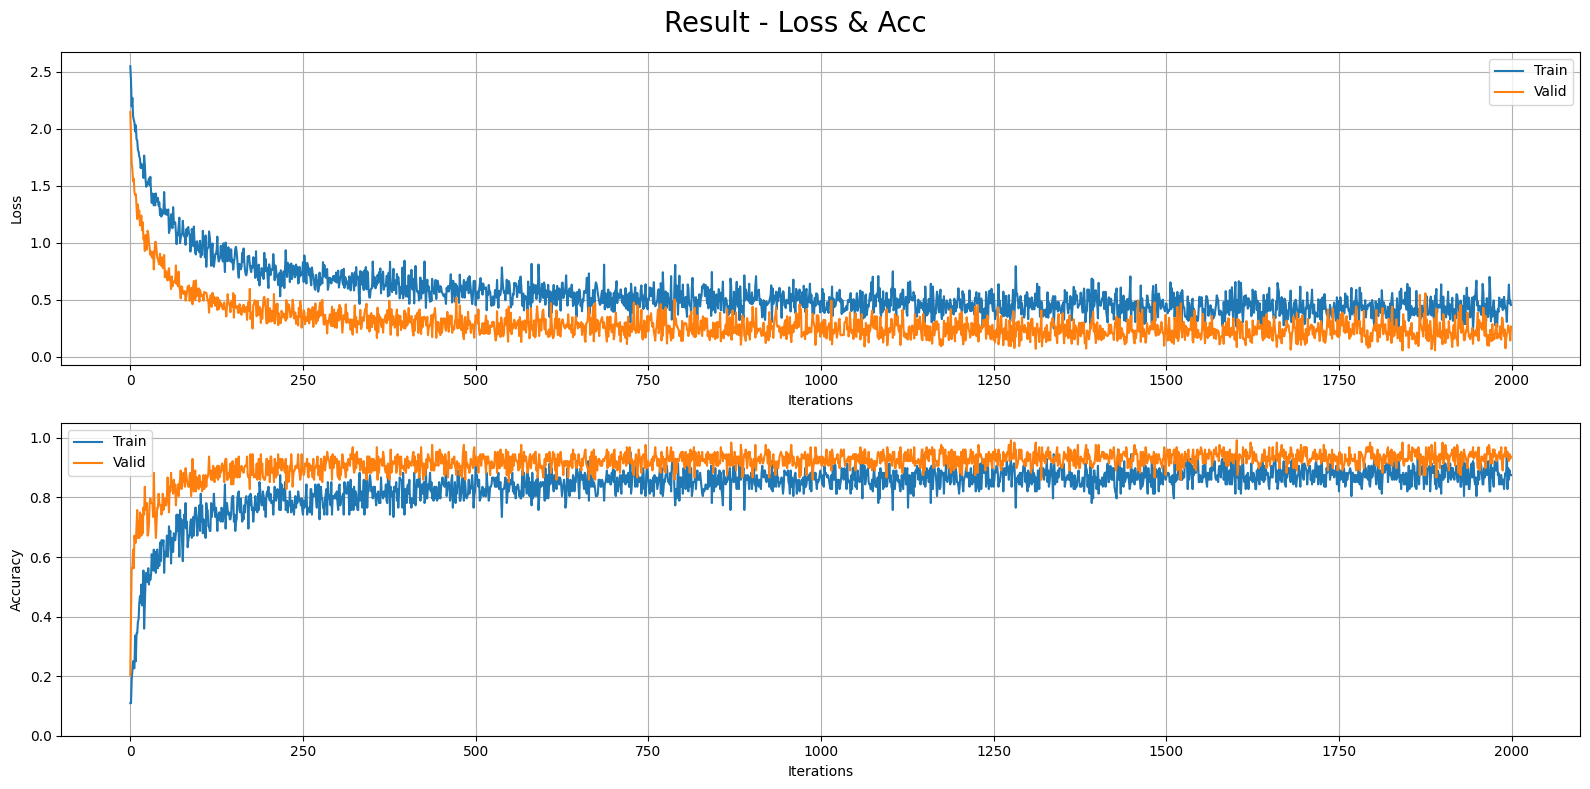

In [40]:
# 모델
model = Net(
    input_size=784,
    hidden_size_list=[100, 100, 100],
    output_size=10,
    use_batchnorm=True,
    weight_init_std='he',
    use_dropout=True,
    dropout_ratio=0.5,
)

# 옵티마이저
optimizer = AdaGrad(lr=0.01)

# 모델 학습 및 검증 시작
trainer_adagrad = Trainer(
    X_train, y_train,
    X_valid, y_valid,
    model=model,
    optimizer=optimizer,
    max_iterations=2000,
    batch_size=128,
)
trainer_adagrad.run()

# 결과 시각화
trainer_adagrad.show_results()

#### 📚 <font color='blue'><b>[ 자료 ]</b></font>

* ["Adaptive Subgradient Methods for Online Learning and Stochastic Optimization" by John Duchi, Elad Hazan, and Yoram Singer.](https://) : AdaGrad 알고리즘을 처음 소개한 논문입니다.
* ["Deep Learning" by Goodfellow et al.]() : AdaGrad와 관련된 자세한 설명이 포함되어 있습니다.


### 4-5. RMSProp

> 세부 목차 개요 : RMSprop는 각 매개변수에 대해 학습률을 개별적으로 조절하는 최적화 알고리즘이다. AdaGrad의 문제를 해결하기 위해, 최근 기울기만($\beta$로 계산) 크게 반영하도록 설계되었다. 이를 통해 학습률이 너무 빠르게 감소하는 문제를 방지하며, 안정적으로 학습을 진행할 수 있다.

$$ h \leftarrow \beta h + (1-\beta) (\frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W}) $$

$$ W \leftarrow W - \eta \frac{1}{\sqrt{h+\epsilon}} \odot \frac{\partial L}{\partial W} $$


#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> RMSProp 구현하기

In [41]:
class RMSprop:

    # 학습률(learning rate)와 감쇠율(decay rate) 설정
    def __init__(self, lr=0.01, decay_rate=0.99):
        self.lr = lr                  # 학습률 설정
        self.decay_rate = decay_rate  # 감쇠율 설정
        self.h = None                 # 이전 기울기의 제곱 합의 이동 평균을 저장할 변수 초기화

    # 파라미터 업데이트 함수
    def update(self, params, grads):

        # 첫 번째 호출 시 h를 파라미터와 동일한 형상의 0으로 초기화
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        # 각 파라미터에 대해
        for key in params.keys():

            # h를 감쇠율로 감소시키고
            self.h[key] *= self.decay_rate

            # 기울기의 제곱의 (1-감쇠율) 비율을 더한다.
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]

            # 파라미터 업데이트 (RMSprop 특징 부분)
            # 0으로 나누는 것을 방지하기 위한 작은 상수 추가
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

#### 📝 <font color='orange'><b>[ 설명 ]</b></font>
* AdaGrad의 학습률 감소 문제를 해결하기 위한 방법 중 하나로 제안되었습니다.
* 과거의 모든 기울기를 균일하게 더하는 대신, 더 최근의 기울기를 크게 반영하는 지수 이동 평균을 사용합니다. 이 방법을 통해, RMSprop는 너무 빠른 학습률의 감소를 방지하면서도 안정적인 학습을 가능하게 합니다.
* $h$는 기울기의 제곱의 지수 이동 평균으로 갱신된다. 학습률을 $\frac{1}{\sqrt{h}}$를 사용해 조절합니다.

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 위에서 구현한 RMSProp 옵티마이저로 학습하기


[Elpased Time: 0:00:00.030100] Iter:    0 Train Loss : 2.5098 Train Acc : 0.12 Valid Loss : 2.2956 Valid Acc : 0.20 
[Elpased Time: 0:00:00.671896] Iter:  100 Train Loss : 0.5520 Train Acc : 0.83 Valid Loss : 0.2572 Valid Acc : 0.93 
[Elpased Time: 0:00:01.452137] Iter:  200 Train Loss : 0.5349 Train Acc : 0.85 Valid Loss : 0.1662 Valid Acc : 0.94 
[Elpased Time: 0:00:02.028152] Iter:  300 Train Loss : 0.5693 Train Acc : 0.84 Valid Loss : 0.0819 Valid Acc : 0.97 
[Elpased Time: 0:00:02.814852] Iter:  400 Train Loss : 0.4799 Train Acc : 0.88 Valid Loss : 0.2574 Valid Acc : 0.94 
[Elpased Time: 0:00:04.608464] Iter:  500 Train Loss : 0.2871 Train Acc : 0.91 Valid Loss : 0.2094 Valid Acc : 0.95 
[Elpased Time: 0:00:05.222421] Iter:  600 Train Loss : 0.2816 Train Acc : 0.91 Valid Loss : 0.1661 Valid Acc : 0.95 
[Elpased Time: 0:00:05.857718] Iter:  700 Train Loss : 0.3217 Train Acc : 0.92 Valid Loss : 0.1703 Valid Acc : 0.95 
[Elpased Time: 0:00:06.400958] Iter:  800 Train Loss : 0.2489 Tr

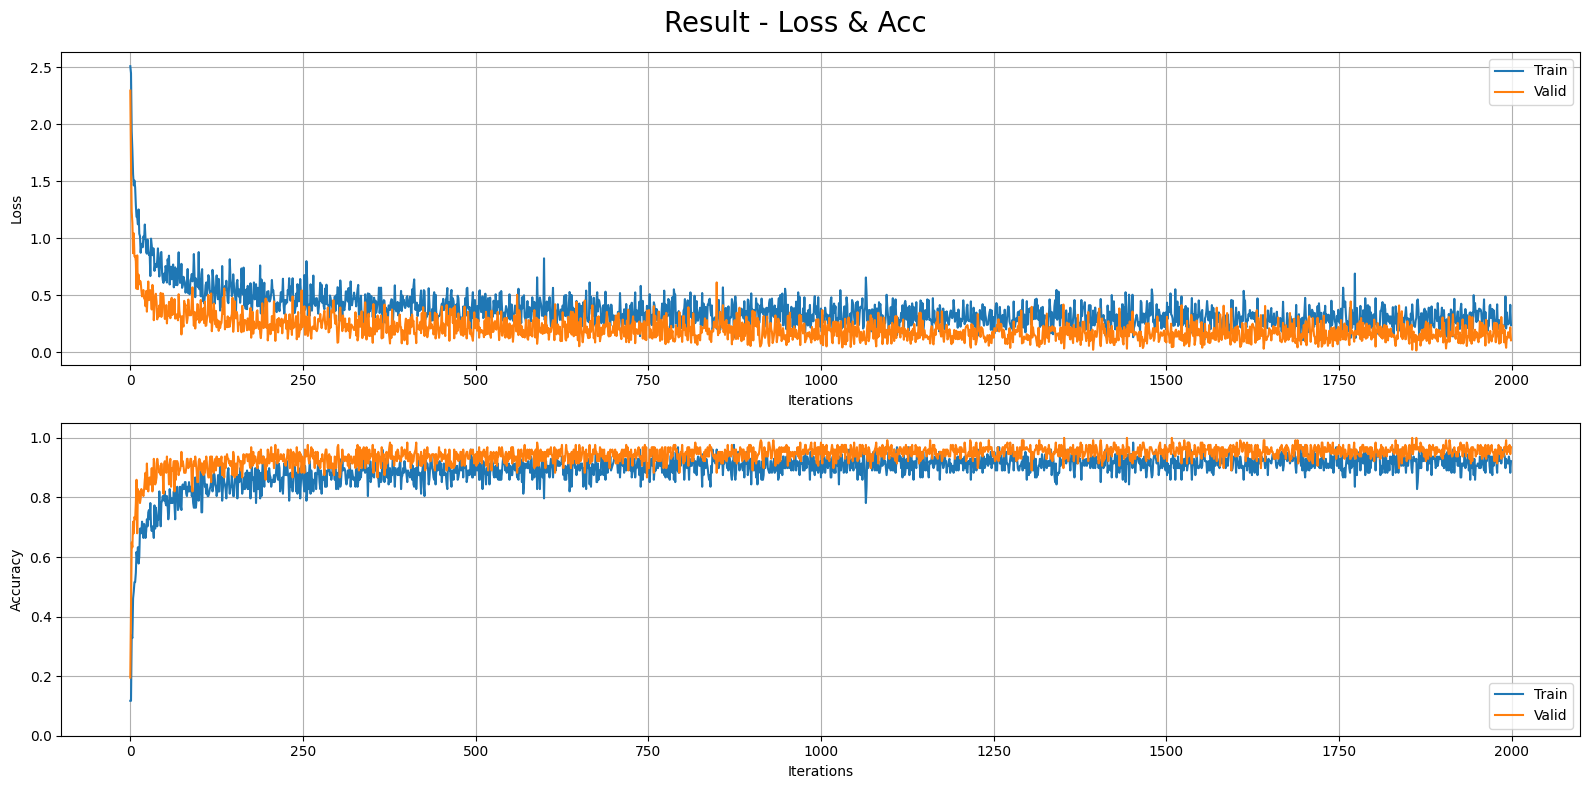

In [42]:
# 모델
model = Net(
    input_size=784,
    hidden_size_list=[100, 100, 100],
    output_size=10,
    use_batchnorm=True,
    weight_init_std='he',
    use_dropout=True,
    dropout_ratio=0.5,
)

# 옵티마이저
optimizer = RMSprop(lr=0.01, decay_rate=0.99)

# 모델 학습 및 검증 시작
trainer_rmsprop = Trainer(
    X_train, y_train,
    X_valid, y_valid,
    model=model,
    optimizer=optimizer,
    max_iterations=2000,
    batch_size=128,
)
trainer_rmsprop.run()

# 결과 시각화
trainer_rmsprop.show_results()

#### 📚 <font color='blue'><b>[ 자료 ]</b></font>
* [Geoffrey Hinton의 Coursera 강의 "Neural Networks for Machine Learning".](https://) : RMSprop 알고리즘이 처음 소개합니다. 한번 살펴보세요.
* ["Deep Learning" by Goodfellow et al.]() : AdaGrad와 관련된 자세한 설명이 포함되어 있습니다.

### 4-6. Adam

> 세부 목차 개요 : Adam은 모멘텀과 RMSprop의 아이디어를 결합한 최적화 알고리즘입니다. 기울기의 지수 이동 평균과 기울기의 제곱의 지수 이동 평균을 동시에 추정하며, 바이어스 보정을 사용하여 초기 단계에서의 계산 바이어스를 제거합니다.

$$ m \leftarrow \beta_{1}m + (1-\beta_{1})\frac{\partial L}{\partial W} $$

$$ v \leftarrow \beta_{2}v + (1-\beta_{2})(\frac{\partial L}{\partial W})^2 $$

$$ W \leftarrow W - \eta \frac{m}{\sqrt{v} + \epsilon} $$

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> Adam 구현하기

In [43]:
class Adam:

    # Adam의 기본 하이퍼파라미터들을 초기화
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr       # 학습률
        self.beta1 = beta1 # 모멘텀에 사용되는 계수
        self.beta2 = beta2 # RMSprop에 사용되는 계수
        self.iter = 0      # 반복 횟수 저장용
        self.m = None      # 1차 모멘텀용 누적 값
        self.v = None      # 2차 모멘텀용 누적 값 (제곱된 기울기의 이동 평균)

    # 파라미터 업데이트 함수
    def update(self, params, grads):

        # 첫 번째 호출 시 m, v 초기화
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        # 반복 횟수 증가
        self.iter += 1

        # 학습률의 바이어스 보정 (bias correction)
        # 이는 초기 불안정한 학습을 안정적으로 도와줌
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        # 각 파라미터에 대해
        for key in params.keys():

            # 1차 모멘텀 계산
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])

            # 2차 모멘텀 (제곱된 기울기의 이동 평균) 계산
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])

            # 파라미터 업데이트
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

#### 📝 <font color='orange'><b>[ 설명 ]</b></font>
* 첫 번째 모멘텀(m)은 과거 기울기의 지수 이동 평균을 추정합니다.
* 두 번째 모멘텀(v)는 과거 기울기의 제곱의 지수 이동 평균을 추정합니다.
* Adam은 바이어스 보정을 사용하여 초반의 계산에서 생기는 작은 값의 바이어스를 제거합니다.
* m은 기울기의 지수 이동 평균으로 갱신된다.
* v는 기울기의 제곱의 지수 이동 평균으로 갱신된다.
* 학습률의 바이어스 보정을 통해 각각의 매개변수 업데이트에 적절한 학습률을 적용한다.

#### 👨‍💻 <font color='green'><b>[ 코드 ]</b></font> 위에서 구현한 Adam 옵티마이저로 학습하기


[Elpased Time: 0:00:00.081023] Iter:    0 Train Loss : 2.6016 Train Acc : 0.07 Valid Loss : 2.4379 Valid Acc : 0.06 
[Elpased Time: 0:00:00.689068] Iter:  100 Train Loss : 1.3401 Train Acc : 0.61 Valid Loss : 0.9390 Valid Acc : 0.73 
[Elpased Time: 0:00:01.266120] Iter:  200 Train Loss : 0.9141 Train Acc : 0.78 Valid Loss : 0.5794 Valid Acc : 0.87 
[Elpased Time: 0:00:01.878085] Iter:  300 Train Loss : 0.6470 Train Acc : 0.83 Valid Loss : 0.4332 Valid Acc : 0.89 
[Elpased Time: 0:00:02.452459] Iter:  400 Train Loss : 0.6789 Train Acc : 0.78 Valid Loss : 0.5217 Valid Acc : 0.85 
[Elpased Time: 0:00:03.119850] Iter:  500 Train Loss : 0.4634 Train Acc : 0.84 Valid Loss : 0.2285 Valid Acc : 0.91 
[Elpased Time: 0:00:04.100709] Iter:  600 Train Loss : 0.5217 Train Acc : 0.84 Valid Loss : 0.1916 Valid Acc : 0.95 
[Elpased Time: 0:00:04.985633] Iter:  700 Train Loss : 0.4008 Train Acc : 0.90 Valid Loss : 0.1957 Valid Acc : 0.94 
[Elpased Time: 0:00:05.645398] Iter:  800 Train Loss : 0.4457 Tr

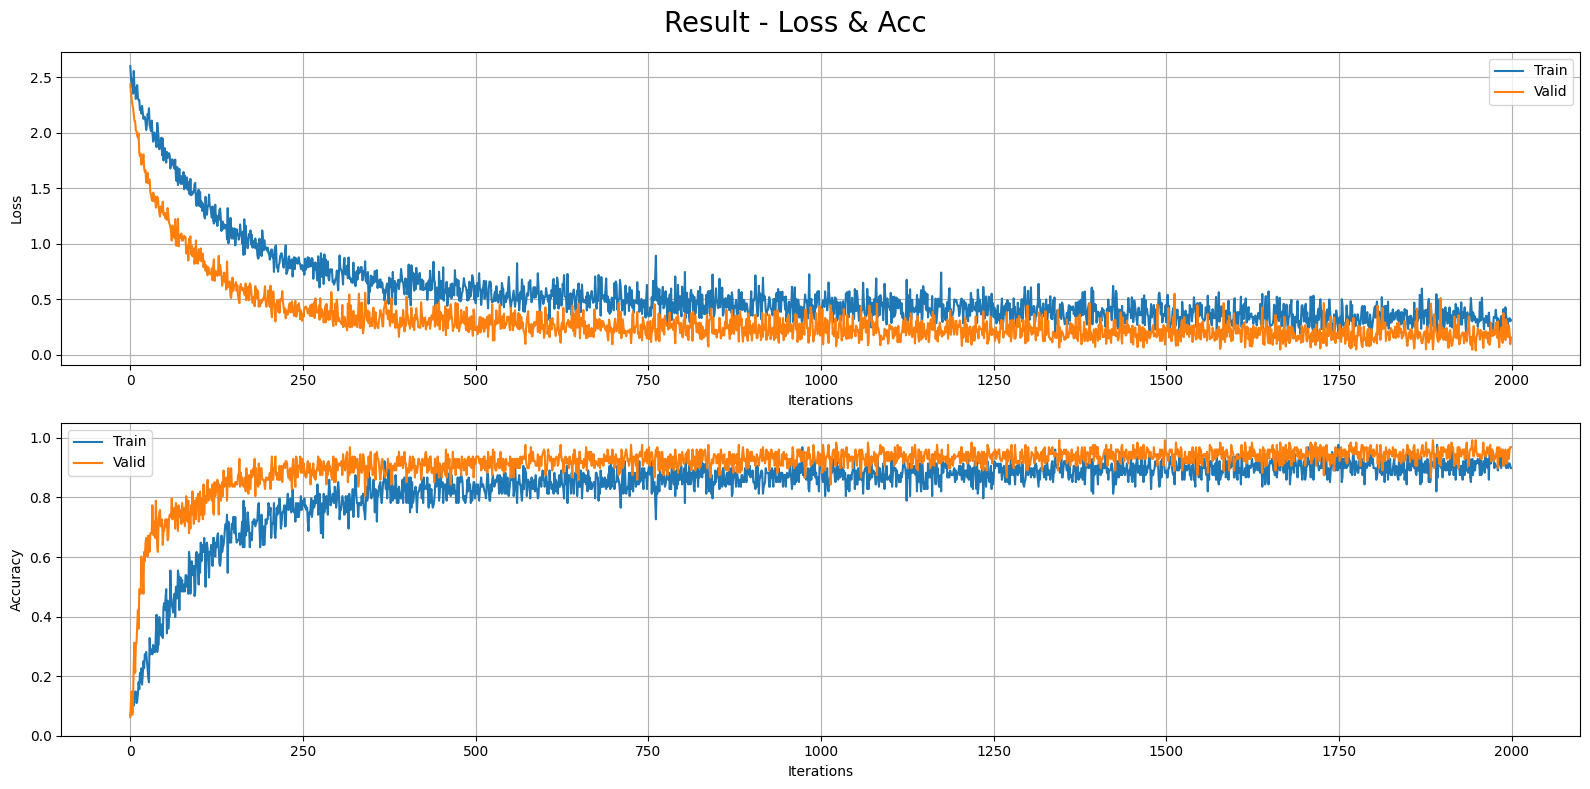

In [44]:
# 모델
model = Net(
    input_size=784,
    hidden_size_list=[100, 100, 100],
    output_size=10,
    use_batchnorm=True,
    weight_init_std='he',
    use_dropout=True,
    dropout_ratio=0.5,
)

# 옵티마이저
optimizer = Adam(lr=0.001, beta1=0.9, beta2=0.999)

# 모델 학습 및 검증 시작
trainer_adam = Trainer(
    X_train, y_train,
    X_valid, y_valid,
    model=model,
    optimizer=optimizer,
    max_iterations=2000,
    batch_size=128,
)
trainer_adam.run()

# 결과 시각화
trainer_adam.show_results()

#### 📚 <font color='blue'><b>[ 자료 ]</b></font>
* [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980) : Adam 알고리즘이 처음 소개된 원본 논문입니다. 자세한 수식과 이론적 배경을 참조하실 수 있습니다.
* ["Deep Learning" by Goodfellow et al.]() : Adam 외에도 다양한 최적화 방법에 대한 자세한 설명이 포함되어 있습니다.

#### 📝 <font color='orange'><b>[ 설명 ]</b></font> SGD부터 Adam 비교하기

다양한 최적화 기법에 따라 어떻게 성능이 달라지는지 살펴볼까요? 잊지 말고 꼭 기억해야할 부분은 "어느 상황에서든 항상 좋은" 옵티마이저는 없다는 것입니다.

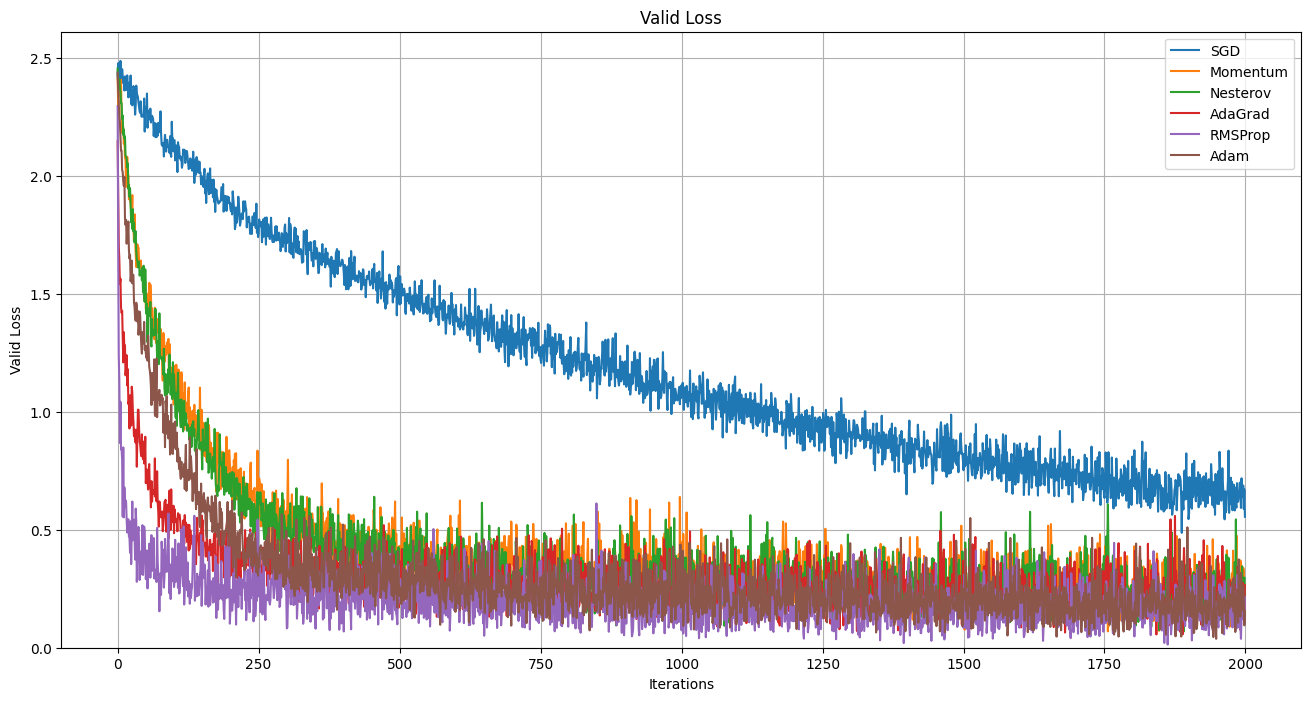

In [45]:
plt.figure(figsize=(16,8))

plt.plot(trainer_sgd.valid_loss_list)
plt.plot(trainer_momentum.valid_loss_list)
plt.plot(trainer_nesterov.valid_loss_list)
plt.plot(trainer_adagrad.valid_loss_list)
plt.plot(trainer_rmsprop.valid_loss_list)
plt.plot(trainer_adam.valid_loss_list)

plt.xlabel('Iterations')
plt.ylabel('Valid Loss')
plt.legend(['SGD', 'Momentum', 'Nesterov', 'AdaGrad', 'RMSProp', 'Adam'])
plt.ylim(0,)

plt.title('Valid Loss')
plt.grid(True)
plt.show()

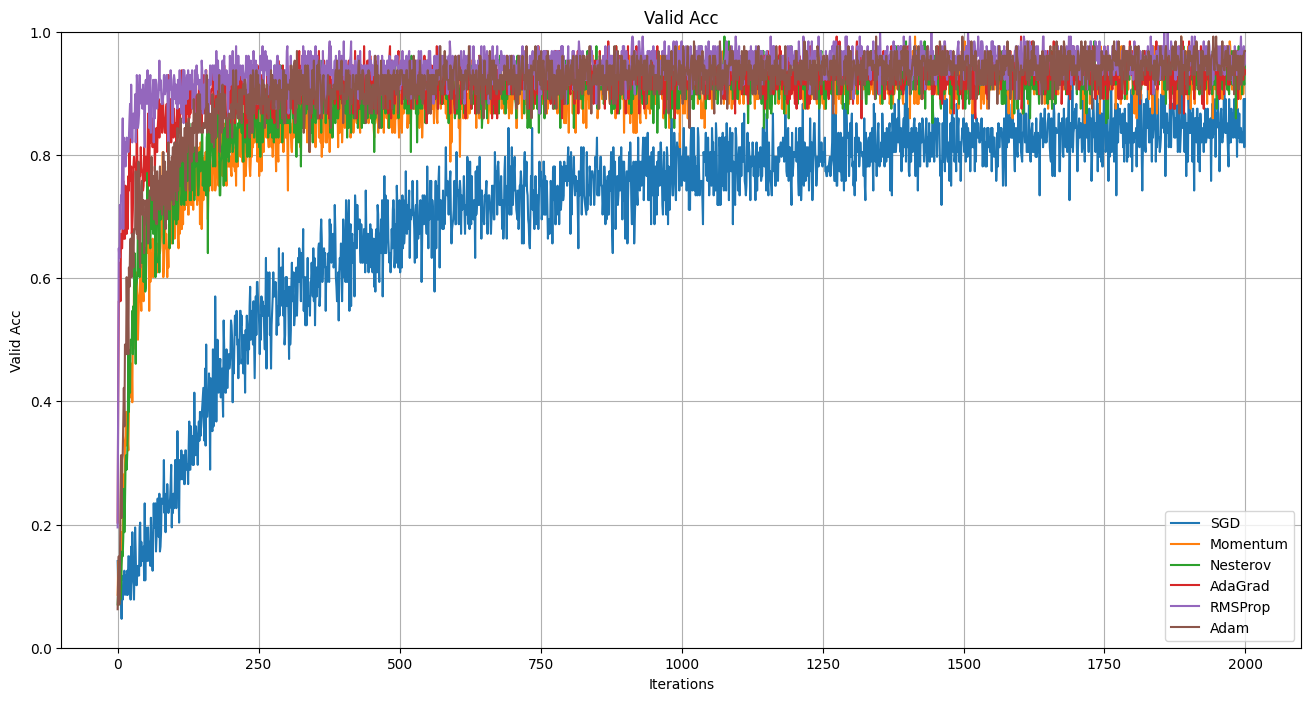

In [46]:
plt.figure(figsize=(16,8))

plt.plot(trainer_sgd.valid_acc_list)
plt.plot(trainer_momentum.valid_acc_list)
plt.plot(trainer_nesterov.valid_acc_list)
plt.plot(trainer_adagrad.valid_acc_list)
plt.plot(trainer_rmsprop.valid_acc_list)
plt.plot(trainer_adam.valid_acc_list)

plt.xlabel('Iterations')
plt.ylabel('Valid Acc')
plt.legend(['SGD', 'Momentum', 'Nesterov', 'AdaGrad', 'RMSProp', 'Adam'])
plt.ylim(0,1)

plt.title('Valid Acc')
plt.grid(True)
plt.show()

## Reference

<hr style="height:5px;border:none;color:#5F71F7;background-color:#5F71F7">

- [MNIST 데이터셋 이미지 출처](https://upload.wikimedia.org/wikipedia/commons/f/f7/MnistExamplesModified.png)

## Required Package

numpy version >= 1.23.5 <br>
matplotlib version >= 3.7.1

## 콘텐츠 라이선스

저작권 : <font color='blue'> <b> ©2023 by Upstage X fastcampus Co., Ltd. All rights reserved.</font></b>

<font color='red'><b>WARNING</font> : 본 교육 콘텐츠의 지식재산권은 업스테이지 및 패스트캠퍼스에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다. </b>